# Legend

Case Study - Legend :

Dataset ini terdiri dari 4 csv file yaitu customer, store, product dan transaction. Merupakan dummy data untuk studi kasus FMCG dalam kurun waktu 1 tahun yang diambil melalui program membership.

Penjelasan 
1. Customer
- CustomerID : No Unik Customer
- Age : Usia Customer
- Gender : 0 Wanita, 1 Pria
- Marital Status : Married, Single (Blm menikah/Pernah menikah)
- Income : Pendapatan per bulan dalam jutaan rupiah

2. Store
- StoreID : Kode Unik Store
- StoreName : Nama Toko
- GroupStore : Nama group
- Type : Modern Trade, General Trade
- Latitude : Kode Latitude
- Longitude : Kode Longitude

3. Product
- ProductID : Kode Unik Product
- Product Name : Nama Product
- Price : Harga dlm rupiah

4. Transaction
- TransactionID : Kode Unik Transaksi
- Date : Tanggal transaksi
- Qty : Jumlah item yang dibeli
- Total Amount : Price x Qty

# Install Library

In [1]:
try:
    # it already installed dependencies
    from torchsummary import summary
    from torchviz import make_dot
except:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import
    from torchsummary import summary
    from torchviz import make_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f7defa13a4a326c5a3184a851453298951c058096a2eb72655f43f2198e68ffd
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
!pip install -q statsforecast mlforecast neuralforecast
!pip install -q prophet
!pip install -q pycaret
!pip install -q pmdarima

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [3]:
!pip install -q neuralprophet
!pip uninstall torchvision -y -q
!pip install -q torchvision

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralforecast 1.6.3 requires pytorch-lightning>=2.0.0, but you have pytorch-lightning 1.9.5 which is incompatible.
neuralforecast 1.6.3 requires torch>=2.0.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.0.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.15.1+cpu requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
neuralforecast 1.6.3 requires pytorch-lightning>=2.0.0, but you have pyt

# Import data

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Transaction.csv
/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Legend.txt
/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Customer.csv
/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Store.csv
/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Product.csv


# Function

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AutoReg

def eacf(z, ar_max=7, ma_max=13, display=True):
    def lag(z, lag):
        return pd.Series(z).shift(lag)

    def reupm(m):
        nrow, ncol = m.shape
        m2 = np.zeros((nrow, ncol - 1))
        for i in range(ncol - 1):
            i1 = i + 1
            work = lag(m[:, i], lag=1)
            work[0] = -1
            temp = m[:, i1] - work * m[i1, i1] / m[i, i]
            temp[i1] = 0
            m2[:, i] = temp
        return m2

    def ceascf(m, cov1, nar, count, z, zm):
        result = np.zeros(nar + 1)
        result[0] = cov1[nar + count - 1]
        for i in range(1, nar + 1):
            A = np.column_stack((z[i:], zm[i:, :i]))
            b = np.r_[1, -m[:i, i - 1]]
            temp = A @ b
            result[i] = acf(temp, nlags=count, fft=False)[count]
        return result

    ar_max += 1
    ma_max += 1
    nar, nma = ar_max - 1, ma_max
    ncov = nar + nma + 2
    nrow, ncol = nar + nma + 1, nar + nma
    z = np.array(z) - np.mean(z)
    zm = np.column_stack([lag(z, lag=i + 1) for i in range(nar)])
    cov1 = np.r_[np.flip(acf(z, nlags=ncov, fft=False)[1:]), acf(z, nlags=ncov, fft=False)]
    ncov += 1
    m1 = np.zeros((nrow, ncol))
    for i in range(ncol):
        m1[:i + 1, i] = AutoReg(z, lags=i + 1, trend='c').fit().params[1:]

    eacfm = np.zeros((ar_max, nma))
    for i in range(nma):
        m1 = reupm(m1)
        ncol -= 1
        eacfm[:, i] = ceascf(m1, cov1, nar, i + 1, z, zm)

    work = np.arange(1, nar + 2)
    work = len(z) - work + 1
    symbol = np.where(np.abs(eacfm) > 2 / np.sqrt(work[:, np.newaxis]), 'x', 'o')

    if display:
        print('AR / MA')
        print(pd.DataFrame(symbol))

    return {
        'eacf': eacfm,
        'ar.max': ar_max,
        'ma.max': ma_max,
        'symbol': pd.DataFrame(symbol)
    }

In [6]:
import numpy as np
import pandas as pd

def smape_metric(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    Parameters:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.

    Returns:
    float: SMAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    # Handle cases where denominator is zero
    denominator[denominator == 0] = 1  # Avoid division by zero

    smape_value = np.mean(numerator / denominator)

    return smape_value

# Load Dataframe

In [7]:
from IPython.display import display

customer_df = pd.read_csv('/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Customer.csv',sep=';')
product_df  = pd.read_csv('/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Product.csv',sep=';')
store_df    = pd.read_csv('/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Store.csv',sep=';')
trans_df    = pd.read_csv('/kaggle/input/kalbe-rakamin/Data_Kalbe/Case Study - Transaction.csv',sep=';')

display(customer_df)
display(product_df)
display(store_df)
display(trans_df)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
5,6,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
6,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"
7,8,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4
...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13


# Cleansing Data

## Customer Data

In [8]:
customer_df.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [9]:
customer_df[customer_df["Marital Status"].isna()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [10]:
customer_df["Marital Status"] = customer_df["Marital Status"].fillna(customer_df["Marital Status"].value_counts(ascending=False).index[0])
customer_df

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,Married,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


Marital Status: <br>
- 0 untuk wanita
- 1 untuk pria

In [11]:
customer_df.Income = customer_df.Income.str.replace(',','.').astype('float64')
customer_df

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57
...,...,...,...,...,...
442,443,33,1,Married,9.28
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81


In [12]:
customer_df.dtypes

CustomerID          int64
Age                 int64
Gender              int64
Marital Status     object
Income            float64
dtype: object

## Product data

In [13]:
product_df.isna().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

## Store Data

In [14]:
store_df.isna().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [15]:
store_df.Latitude = store_df.Latitude.str.replace(',','.').astype('float64')
store_df.Longitude = store_df.Longitude.str.replace(',','.').astype('float64')
store_df

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845
5,6,Lingga,Lingga,Modern Trade,-5.135399,119.423790
6,7,Buana Indah,Buana,General Trade,3.316694,114.590111
7,8,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753
8,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643
9,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513


In [16]:
store_df.dtypes

StoreID         int64
StoreName      object
GroupStore     object
Type           object
Latitude      float64
Longitude     float64
dtype: object

# Transaction Data

In [17]:
trans_df.isna().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [18]:
trans_df.dtypes

TransactionID    object
CustomerID        int64
Date             object
ProductID        object
Price             int64
Qty               int64
TotalAmount       int64
StoreID           int64
dtype: object

# Merging data

In [19]:
master_df = pd.merge(trans_df,store_df,
                     left_on='StoreID',
                     right_on='StoreID',
                     how='left'
                    )
master_df = pd.merge(master_df,product_df,
                     left_on='ProductID',
                     right_on='ProductID',
                     how='left'
                    )
master_df = pd.merge(master_df,customer_df,
                     left_on='CustomerID',
                     right_on='CustomerID',
                     how='left'
                    )
master_df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y,Age,Gender,Marital Status,Income
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500,36,0,Married,10.53
1,TR16356,165,01/01/2022,P9,10000,7,70000,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Yoghurt,10000,44,1,Married,14.58
2,TR1984,183,01/01/2022,P1,8800,4,35200,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Choco Bar,8800,27,1,Single,0.18
3,TR35256,160,01/01/2022,P1,8800,7,61600,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Choco Bar,8800,48,1,Married,12.57
4,TR41231,386,01/01/2022,P9,10000,1,10000,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Yoghurt,10000,33,0,Married,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529,Cheese Stick,15000,38,0,Married,3.34
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Ginger Candy,3200,29,0,Married,4.74
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Coffee Candy,9400,37,0,Married,3.73
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13,Buana,Buana,General Trade,-1.269160,116.825264,Oat,16000,47,0,Married,13.60


In [20]:
from ydata_profiling import ProfileReport
profile = ProfileReport(master_df, title="EDA master df")
profile.to_file("EDA_master_df.html")

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/typeset_relations.py:116: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  return series.astype("datetime64")
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/typeset_relations.py:116: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  return series.astype("datetime64")
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/typeset_relations.py:116: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  return series.astype("datetime64")
/opt/conda/lib/python3.10/site-packages/ydata_profiling

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
master_df_reg = master_df.drop(['TransactionID', 'CustomerID',
                            'ProductID', 'StoreID','Price_y'
                           ],
                           axis=1)
master_df_reg.Date = pd.to_datetime(master_df_reg.Date,
                                format='%d/%m/%Y'
                               )
master_df_reg

,Date,Price_x,Qty,TotalAmount,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Age,Gender,Marital Status,Income
0,2022-01-01,7500,4,30000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,36,0,Married,10.53
1,2022-01-01,10000,7,70000,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Yoghurt,44,1,Married,14.58
2,2022-01-01,8800,4,35200,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Choco Bar,27,1,Single,0.18
3,2022-01-01,8800,7,61600,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Choco Bar,48,1,Married,12.57
4,2022-01-01,10000,1,10000,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Yoghurt,33,0,Married,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,2022-12-31,15000,5,75000,Prima Kota,Prima,Modern Trade,-7.797068,110.370529,Cheese Stick,38,0,Married,3.34
5016,2022-12-31,3200,4,12800,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Ginger Candy,29,0,Married,4.74
5017,2022-12-31,9400,6,56400,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Coffee Candy,37,0,Married,3.73
5018,2022-12-31,16000,3,48000,Buana,Buana,General Trade,-1.269160,116.825264,Oat,47,0,Married,13.60


In [22]:
master_df.StoreName.unique()

array(['Prestasi Utama', 'Prima Tendean', 'Gita Ginara', 'Bonafid',
       'Prima Kelapa Dua', 'Buana', 'Priangan', 'Harapan Baru',
       'Prima Kota', 'Lingga', 'Buana Indah', 'Sinar Harapan'],
      dtype=object)

In [23]:
master_df.GroupStore.unique()

array(['Prestasi', 'Prima', 'Gita', 'Buana', 'Priangan', 'Harapan Baru',
       'Lingga'], dtype=object)

In [24]:
master_df.Type.unique()

array(['General Trade', 'Modern Trade'], dtype=object)

In [25]:
master_df.columns

Index(['TransactionID', 'CustomerID', 'Date', 'ProductID', 'Price_x', 'Qty',
       'TotalAmount', 'StoreID', 'StoreName', 'GroupStore', 'Type', 'Latitude',
       'Longitude', 'Product Name', 'Price_y', 'Age', 'Gender',
       'Marital Status', 'Income'],
      dtype='object')

In [26]:
master_df_reg = master_df_reg.groupby(['Date']).agg({
    'Qty':'sum'
})
master_df_reg = master_df_reg.reset_index()
master_df_reg

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


# Regression

## ARIMA

In [27]:
profile = ProfileReport(master_df_reg, title="EDA master df reg")
profile.to_file('EDA_master_df_reg.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Step 1: Import necessary libraries

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

master_df_reg_ar = master_df_reg.copy() 
train_ts,test_ts =  master_df_reg_ar['Qty'][:-30],master_df_reg_ar['Qty'][-30:]
display(train_ts)
display(test_ts)

0      49
1      59
2      63
3      45
4      30
       ..
330    53
331    50
332    55
333    45
334    81
Name: Qty, Length: 335, dtype: int64

335    30
336    48
337    63
338    33
339    41
340    35
341    33
342    45
343    49
344    42
345    52
346    50
347    26
348    46
349    29
350    35
351    54
352    29
353    41
354    64
355    30
356    26
357    74
358    53
359    39
360    70
361    68
362    42
363    44
364    37
Name: Qty, dtype: int64

### Step 2: Check Normality


Jarque-Bera Test Statistic: 23.738525550155458
Jarque-Bera Test p-value: 7.002363835851646e-06
Skewness: 0.5654405629003157
Excess Kurtosis: 3.6494446600621275


<Axes: xlabel='Qty', ylabel='Density'>

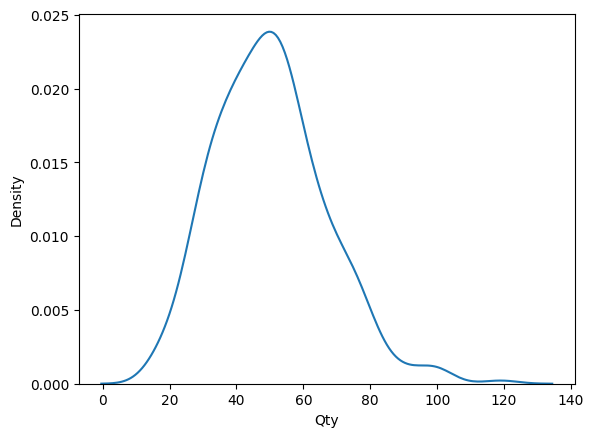

In [29]:
from statsmodels.stats.stattools import jarque_bera
from sklearn.preprocessing import PowerTransformer

jb_statistic, jb_p_value, skewness, kurtosis = jarque_bera(train_ts)

# Print the results
print(f'Jarque-Bera Test Statistic: {jb_statistic}')
print(f'Jarque-Bera Test p-value: {jb_p_value}')
print(f'Skewness: {skewness}')
print(f'Excess Kurtosis: {kurtosis}')
import seaborn as sns
sns.kdeplot(master_df_reg_ar['Qty'])

Jarque-Bera Test Statistic: [0.06197441]
Jarque-Bera Test p-value: [0.96948798]
Skewness: [0.00094638]
Excess Kurtosis: [3.06660612]


<Axes: ylabel='Density'>

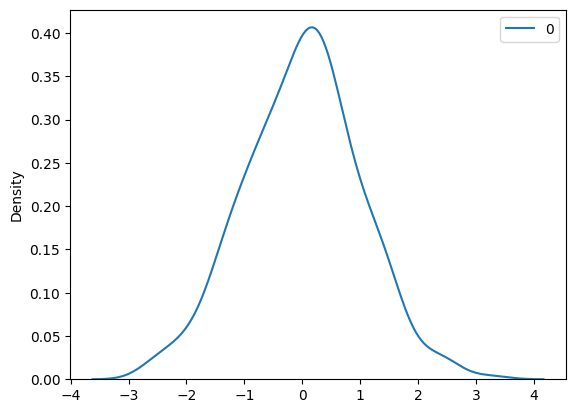

In [30]:
pow_tr = PowerTransformer(method='box-cox')
hasil_pow_tr = pow_tr.fit_transform(train_ts.to_numpy().reshape((-1,1)))

jb_statistic, jb_p_value, skewness, kurtosis = jarque_bera(hasil_pow_tr)

# Print the results
print(f'Jarque-Bera Test Statistic: {jb_statistic}')
print(f'Jarque-Bera Test p-value: {jb_p_value}')
print(f'Skewness: {skewness}')
print(f'Excess Kurtosis: {kurtosis}')
import seaborn as sns
sns.kdeplot(hasil_pow_tr)

<Axes: ylabel='Density'>

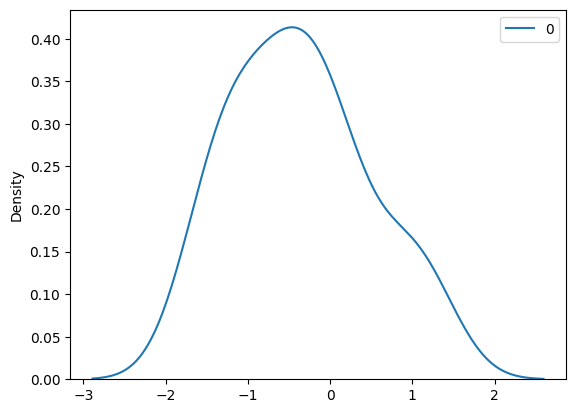

In [31]:
train_ts = pow_tr.fit_transform(train_ts.to_numpy().reshape((-1,1)))
test_ts  = pow_tr.transform(test_ts.to_numpy().reshape((-1,1)))
sns.kdeplot(test_ts)

### Step 3: Perform stationarity tests and differencing if needed


In [32]:
train_ts = pd.Series(train_ts.ravel())
test_ts = pd.Series(test_ts.ravel())

In [33]:
def test_stationarity(ts):
    # Perform Dickey-Fuller test
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

    if result[1] <= 0.05:
        print("Time series is stationary")
        return True
    else:
        print("Time series is not stationary")
        return False

    
# Check stationarity and apply differencing if needed
if not test_stationarity(train_ts):
    print('do differencing...')
    train_ts = train_ts.diff().dropna()
else:
    print("Don't differencing...")
    train_ts = train_ts

ADF Statistic: -18.955089181555458
p-value: 0.0
Critical Values:
1%: -3.450081345901191
5%: -2.870232621465807
10%: -2.571401168202517
Time series is stationary
Don't differencing...


### Step 4: Determine ARIMA parameters (p, d, q)


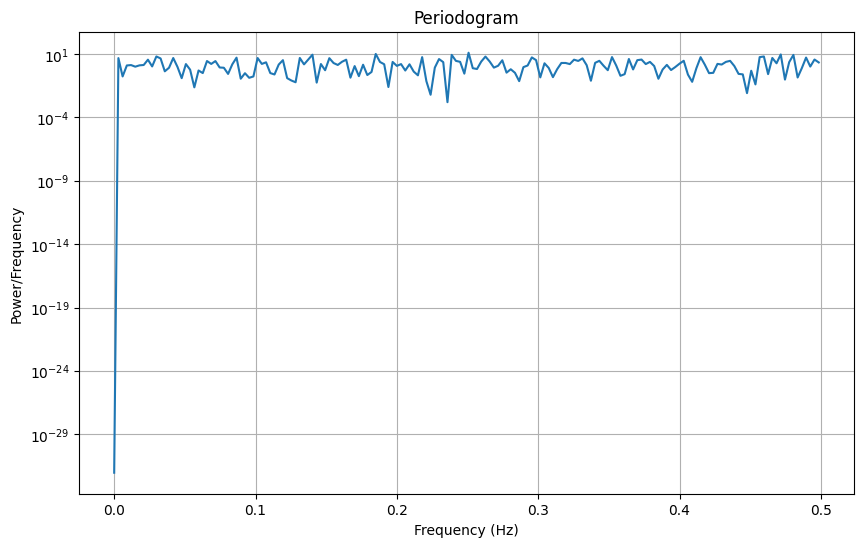

In [34]:
import matplotlib.pyplot as plt
from scipy import signal

# Compute the periodogram using scipy's signal module
frequencies, periodogram = signal.periodogram(train_ts)

# Plot the periodogram
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, periodogram)  # Use semilogy for a logarithmic y-axis
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.title('Periodogram')
plt.grid()
plt.show()

Karena di periodogram memiliki nilai power yang rata. maka disimpulkan tidak ada seasonal yang sesuai

In [35]:
# dominant_frequency = frequencies[np.argmax(periodogram)]
# seasonal_period = 1 / dominant_frequency
# print("Dominant Frequency:", dominant_frequency)
# print("Seasonal Period:", seasonal_period)

#### Plot Seasonal


In [36]:
# master_df_reg_sd = master_df_reg_ar.set_index('Date')
# master_df_reg_sd
# hasil = sm.tsa.seasonal_decompose(master_df_reg_sd, model='additive')
# hasil.plot()

#### Plot ACF,PACF,EACF


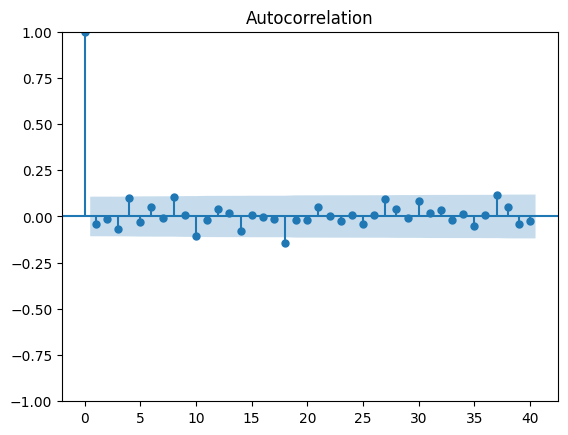

In [37]:
plot_acf(train_ts, lags=40)
plt.show()

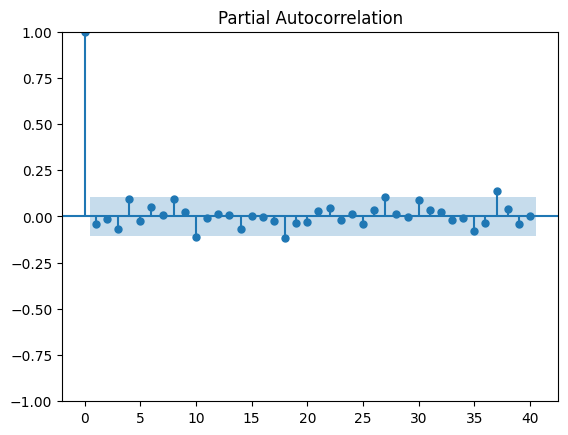

In [38]:
plot_pacf(train_ts, lags=40)
plt.show()

Berdasarkan ini , tentatif ordernya adalah pada ARIMA(0,0,0).

In [39]:
d = 0
hasil_eacf = eacf(train_ts)
order_arima = [(0,d,0),
               (1,d,0),
               (2,d,0),
               (3,d,0),
               (4,d,0),
               (5,d,0),
               (1,d,1),
               (2,d,1),
               (3,d,1),
               (4,d,1),
               (5,d,1),
               (1,d,2),
               (2,d,2),
               (3,d,2),
               (4,d,2),
               (5,d,2),
               (3,d,3),
               (4,d,3),
               (5,d,3),
               (4,d,4),
               (5,d,4),
               (4,d,5),
               (5,d,5),
              ]

AR / MA
  0  1  2  3  4  5  6  7  8  9  10 11 12 13
0  o  o  o  o  o  o  o  o  o  o  o  o  o  o
1  x  o  o  o  o  o  o  o  o  o  o  o  o  o
2  x  x  o  o  o  o  o  o  o  o  o  o  o  o
3  x  x  x  o  o  o  o  o  o  o  o  o  o  o
4  x  x  o  x  o  o  o  o  o  o  o  o  o  o
5  x  x  o  x  o  o  o  o  o  o  o  o  o  o
6  x  x  x  x  o  x  o  o  o  o  o  o  o  o
7  o  x  o  x  o  x  o  o  o  o  o  o  o  o


Ini hanya mencoba kemungkinan order ARIMA yang optimal dengan menggunakan eacf

### Step 5: Fit the ARIMA model
#### Replace the following with your determined values

In [40]:
from IPython.display import display
for lo in order_arima:
    p,d,q = lo
    model = sm.tsa.ARIMA(train_ts, order=(p, d, q))
    results = model.fit()
    _, pvalue, _, _ = results.test_normality(method='jarquebera')[0]
    pvalue = results.test_serial_correlation(method='ljungbox',lags=1)[0][1][0]
    pvalue_coef = results.pvalues
    pvalue_coef = pvalue_coef.drop('const')
    if((pvalue_coef<0.05).all()):
        display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  335
Model:                          ARIMA   Log Likelihood                -475.344
Date:                Tue, 19 Sep 2023   AIC                            954.689
Time:                        12:36:21   BIC                            962.317
Sample:                             0   HQIC                           957.730
                                - 335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.015e-06      0.055  -9.18e-05      1.000      -0.107       0.107
sigma2         1.0000      0.076     13.156      0.000       0.851       1.149
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.43   Prob(JB):                         0.97
Heteroskedasticity (H):               0.90   Skew:                             0.00
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/st

berdasarkan hasil dari percobaan eacf, maka yang terseleksi adalah :
- (0,0,0)
- (3,0,3)
- (5,0,5)

Kemudian, berdasarkan nilai dari AIC dan BIC, maka yang terbaik adalah ARIMA(0,0,0)

### Step 6: Diagnostics and Model Summary

AR-0 MA-0 aic->954.6888172722092 bic->962.3170783358594


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  335
Model:                          ARIMA   Log Likelihood                -475.344
Date:                Tue, 19 Sep 2023   AIC                            954.689
Time:                        12:36:43   BIC                            962.317
Sample:                             0   HQIC                           957.730
                                - 335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.015e-06      0.055  -9.18e-05      1.000      -0.107       0.107
sigma2         1.0000      0.076     13.156      0.000       0.851       1.149
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.43   Prob(JB):                         0.97
Heteroskedasticity (H):               0.90   Skew:                             0.00
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

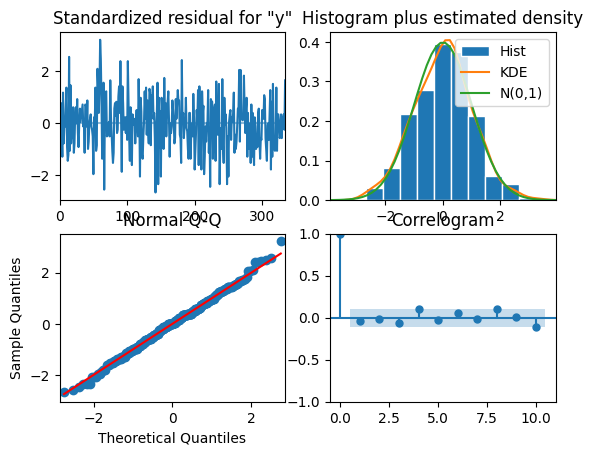

In [41]:
# Step 6: Diagnostics and Model Summary
p,d,q = (0,0,0)
model = sm.tsa.ARIMA(train_ts, order=(p, d, q))
results = model.fit()
print(f'AR-{p} MA-{q} aic->{results.aic} bic->{results.bic}')
display(results.summary())
results.plot_diagnostics()
plt.show()

### Step 7: Plot the Results

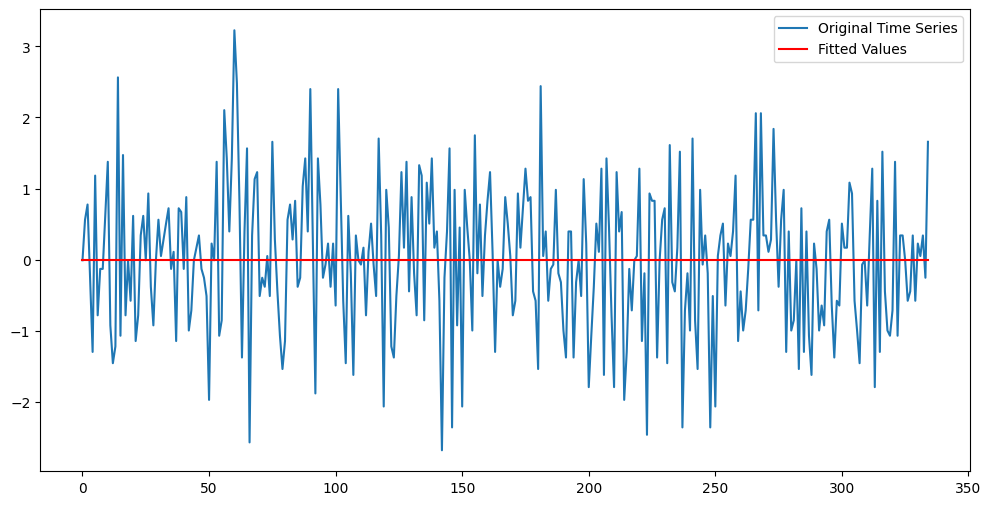

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_ts, label='Original Time Series')
plt.plot(results.fittedvalues, color='red', label='Fitted Values')
plt.legend()
plt.show()

### Step 8 : Validation Forecasting

#### Pengecekan evaluasi pada seluruh time series


##### Normalized


In [43]:
from sklearn.metrics import mean_absolute_percentage_error as mape

nilai_mapeku = mape(y_true=train_ts,
                    y_pred=results.fittedvalues
                   )
print(f'(Normalized) nilai MAPE pada ARIMA(0,0,0)  : {nilai_mapeku * 100} %')

nilai_smapeku = smape_metric(y_true=train_ts,
                             y_pred=results.fittedvalues
                            )
print(f'(Normalized) nilai SMAPE pada ARIMA(0,0,0) : {nilai_smapeku * 100} %')

(Normalized) nilai MAPE pada ARIMA(0,0,0)  : 99.9976278365374 %
(Normalized) nilai SMAPE pada ARIMA(0,0,0) : 199.9874445995598 %


##### Original


In [44]:
from sklearn.metrics import mean_absolute_percentage_error as mape

y_true = pow_tr.inverse_transform(train_ts.to_numpy().reshape((-1,1)))
y_pred = pow_tr.inverse_transform(results.fittedvalues.to_numpy().reshape((-1,1)))

nilai_mapeku = mape(y_true=y_true,
                    y_pred=y_pred
                   )
nilai_smapeku = smape_metric(y_true=y_true,
                             y_pred=y_pred
                            )

print(f'(Original) nilai MAPE pada ARIMA(0,0,0)  : {nilai_mapeku * 100} %')
print(f'(Original) nilai SMAPE pada ARIMA(0,0,0) : {nilai_smapeku * 100} %')


pd.DataFrame(y_pred)

(Original) nilai MAPE pada ARIMA(0,0,0)  : 30.382200292356607 %
(Original) nilai SMAPE pada ARIMA(0,0,0) : 26.69954347805878 %


,0
0,49.145888
1,49.145888
2,49.145888
3,49.145888
4,49.145888
...,...
330,49.145888
331,49.145888
332,49.145888
333,49.145888


#### Pengecekan evaluasi pada pembagian training 11 bulan dengan 1 bulan


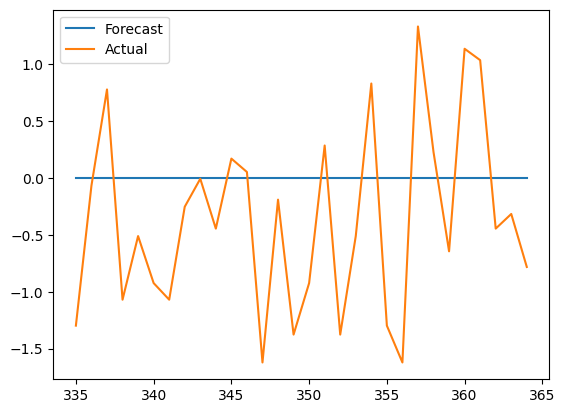

nilai MAPE pada ARIMA(0,0,0) : 0.9999796319498835


In [45]:
# train,test = master_df_reg_ar['Qty'][:-30],master_df_reg_ar['Qty'][-30:]
p,d,q = (0,0,0)
model = sm.tsa.ARIMA(train_ts, order=(p, d, q))
results = model.fit()
forecast_s = results.predict(start=335,end=364)
nilai_mapeku = mape(y_true=test_ts,
                    y_pred=forecast_s
                   )

nilai_smapeku = smape_metric(y_true=test_ts,
                             y_pred=forecast_s
                            )

test_ts.index = forecast_s.index
plt.plot(forecast_s,label='Forecast')
plt.plot(test_ts,label='Actual')
plt.legend()
plt.show()
print(f'nilai MAPE pada ARIMA({p},{d},{q}) : {nilai_mapeku}')

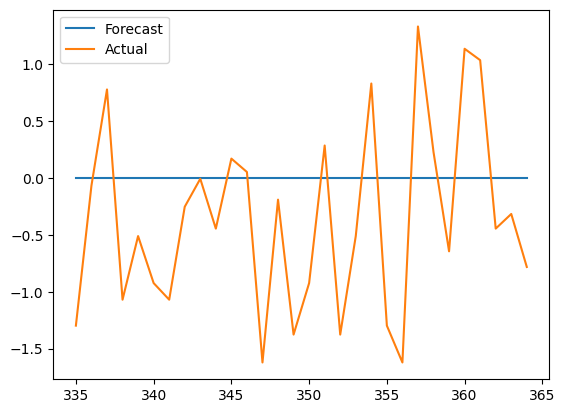

nilai MAPE pada ARIMA(0,0,0)  : 31.53700879333618 %
nilai SMAPE pada ARIMA(0,0,0) : 26.65505417320372 %


In [46]:
# train,test = master_df_reg_ar['Qty'][:-30],master_df_reg_ar['Qty'][-30:]
from sklearn.metrics import mean_absolute_percentage_error

p,d,q = (0,0,0)
model = sm.tsa.ARIMA(train_ts, order=(p, d, q))
results = model.fit()
forecast_s = results.predict(start=335,end=364)

y_trueku = pow_tr.inverse_transform(test_ts.to_numpy().reshape((-1,1)))
y_predku = pow_tr.inverse_transform(forecast_s.to_numpy().reshape((-1,1)))

nilai_mapeku = mean_absolute_percentage_error(y_true=y_trueku,
                    y_pred=y_predku
                   )

nilai_smapeku = smape_metric(y_true=y_trueku,
                             y_pred=y_predku
                            )

test_ts.index = forecast_s.index
plt.plot(forecast_s,label='Forecast')
plt.plot(test_ts,label='Actual')
plt.legend()
plt.show()
print(f'nilai MAPE pada ARIMA({p},{d},{q})  : {nilai_mapeku*100} %')
print(f'nilai SMAPE pada ARIMA({p},{d},{q}) : {nilai_smapeku*100} %')

Mean Absolute Percentage Error (MAPE)             : 99.99796319498834 %
Symmetrical Mean Absolute Percentage Error (SMAPE): 199.9892759052959 %


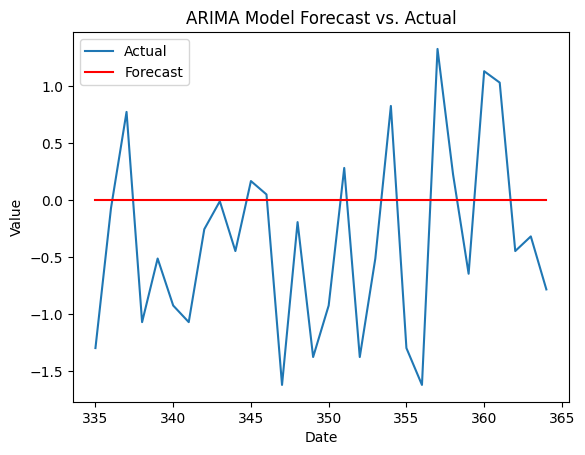

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Define the order of the ARIMA model (p, d, q)
p = 0  # Autoregressive order
d = 0  # Degree of differencing
q = 0  # Moving average order

# Split data into training and validation sets
train_data = train_ts.copy()
validation_data = test_ts.copy()

# Fit the ARIMA model to the training data
model = sm.tsa.ARIMA(train_data, order=(p, d, q))
results = model.fit()

# Make forecasts for the validation set
forecasts = results.forecast(steps=len(validation_data))

# validation_data = pow_tr.inverse_transform(validation_data.to_numpy().reshape((-1,1)))
# forecasts = pow_tr.inverse_transform(forecasts.to_numpy().reshape((-1,1)))

# Calculate Mean Absolute Percentage Error (MAPE) using scikit-learn
mape = mean_absolute_percentage_error(validation_data, forecasts)
smapeku = smape_metric(validation_data, forecasts)
print(f'Mean Absolute Percentage Error (MAPE)             : {mape*100} %')
print(f'Symmetrical Mean Absolute Percentage Error (SMAPE): {smapeku*100} %')

# Visualize the actual vs. forecasted values
# plt.figure(figsize=(12, 6))
plt.plot(#df[train_size:].index, 
         validation_data,
         label='Actual')
plt.plot(#df[train_size:].index, 
         forecasts,
         label='Forecast', 
    color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('ARIMA Model Forecast vs. Actual')
plt.show()

Mean Absolute Percentage Error (MAPE)             : 31.53700879333618 %
Symmetrical Mean Absolute Percentage Error (SMAPE): 26.65505417320372 %


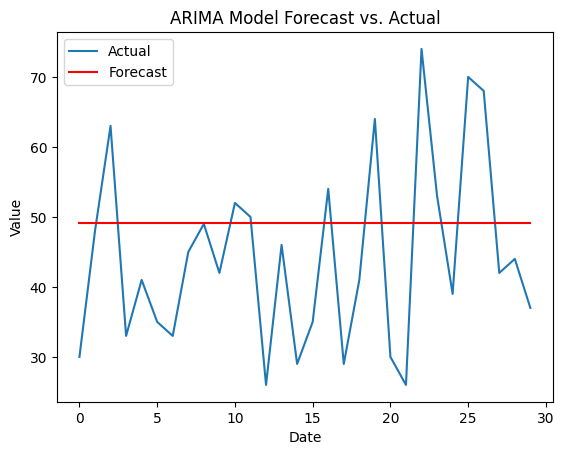

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Define the order of the ARIMA model (p, d, q)
p = 0  # Autoregressive order
d = 0  # Degree of differencing
q = 0  # Moving average order

# Split data into training and validation sets
train_data = train_ts.copy()
validation_data = test_ts.copy()

# Fit the ARIMA model to the training data
model = sm.tsa.ARIMA(train_data, order=(p, d, q))
results = model.fit()

# Make forecasts for the validation set
forecasts = results.forecast(steps=len(validation_data))

validation_data = pow_tr.inverse_transform(validation_data.to_numpy().reshape((-1,1)))
forecasts = pow_tr.inverse_transform(forecasts.to_numpy().reshape((-1,1)))

# Calculate Mean Absolute Percentage Error (MAPE) using scikit-learn
mape = mean_absolute_percentage_error(validation_data, forecasts)
smapeku = smape_metric(validation_data, forecasts)
print(f'Mean Absolute Percentage Error (MAPE)             : {mape*100} %')
print(f'Symmetrical Mean Absolute Percentage Error (SMAPE): {smapeku*100} %')

# Visualize the actual vs. forecasted values
# plt.figure(figsize=(12, 6))
plt.plot(#df[train_size:].index, 
         validation_data,
         label='Actual')
plt.plot(#df[train_size:].index, 
         forecasts,
         label='Forecast', 
    color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('ARIMA Model Forecast vs. Actual')
plt.show()

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Define the order of the ARIMA model (p, d, q)
p = 0  # Autoregressive order
d = 0  # Degree of differencing
q = 0  # Moving average order

# Split data into training and validation sets
scaled_data =  pow_tr.transform(master_df_reg['Qty'].to_numpy().reshape((-1,1)))

# Fit the ARIMA model to the training data
model = sm.tsa.ARIMA(scaled_data, order=(p, d, q))
results = model.fit()

# Make forecasts for the validation set
forecasts = results.forecast(steps=30)
forecasts

array([-0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908,
       -0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908,
       -0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908,
       -0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908,
       -0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908,
       -0.02997908, -0.02997908, -0.02997908, -0.02997908, -0.02997908])

In [50]:
for_ar = pow_tr.inverse_transform(forecasts.reshape((-1,1)))
for_ar = for_ar.ravel()

end_date = master_df_reg.Date.iloc[-1] + np.timedelta64(31, 'D')
date_for = np.arange(master_df_reg.Date.iloc[-1], end_date, np.timedelta64(1, 'D'))
date_for = date_for[1:]
date_for = date_for.astype('datetime64[ns]')

master_ar_reg_for = pd.DataFrame({'Date':date_for,
                                  'Qty_For':for_ar
                                 }
                                )
master_ar_reg_for

,Date,Qty_For
0,2023-01-01,48.647135
1,2023-01-02,48.647135
2,2023-01-03,48.647135
3,2023-01-04,48.647135
4,2023-01-05,48.647135
5,2023-01-06,48.647135
6,2023-01-07,48.647135
7,2023-01-08,48.647135
8,2023-01-09,48.647135
9,2023-01-10,48.647135


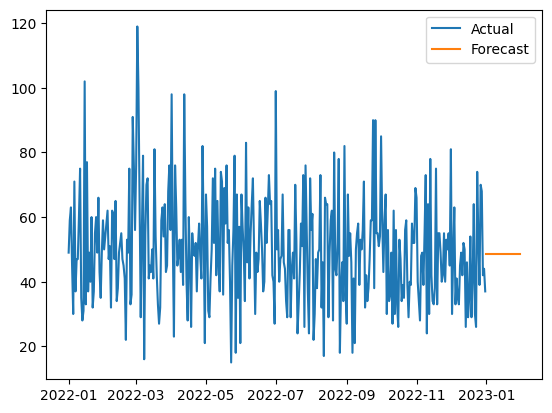

In [51]:
plt.plot(master_df_reg['Date'],master_df_reg['Qty'],label='Actual')
plt.plot(master_ar_reg_for['Date'],master_ar_reg_for['Qty_For'],label='Forecast')
plt.legend()
plt.show()

In [52]:
master_ar_reg_for.to_csv('Forecast_ARIMA.csv',index=False)

## AutoArima

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=954.725, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=956.131, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=956.108, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=952.701, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=958.630, Time=0.93 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.065 seconds


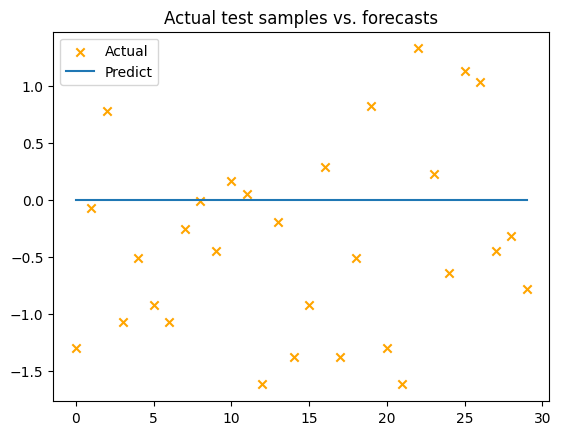

Nilai MAPE  : 1.0
Nilai SMAPE : 2.0


In [53]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
# data = pm.datasets.load_wineind()
# train, test = model_selection.train_test_split(master_df_reg_ar['Qty'], test_size=30)

# Fit a simple auto_arima model
arima = pm.auto_arima(train_ts,
                      start_p=0, d=None,start_q=0, 
                      max_p=10, max_d=2, max_q=10, 
                      start_P=0, D=None, start_Q=0, 
                      max_P=2, max_D=2, max_Q=2,
                      stationary=False, 
                      information_criterion='aicc',
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=1)

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test_ts.shape[0])
plt.scatter(x, test_ts, marker='x',color='orange',
            label='Actual'
           )
plt.plot(x, arima.predict(n_periods=test_ts.shape[0]),
         label='Predict'
        )
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

forecast_au_ar = arima.predict(n_periods=test_ts.shape[0])
nilai_mapeku = mean_absolute_percentage_error(y_true=test_ts,y_pred=forecast_au_ar)
nilai_smapeku = smape_metric(y_true=test_ts,y_pred=forecast_au_ar)


print(f'Nilai MAPE  : {nilai_mapeku}')
print(f'Nilai SMAPE : {nilai_smapeku}')

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=1298.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=1190.814, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=1055.141, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=1296.453, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=1062.178, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=1053.695, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=1053.565, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=1055.004, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AICC=1047.888, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AICC=1068.997, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AICC=inf, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AICC=1050.070, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AICC=1060.436, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AICC=1051.857, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0]

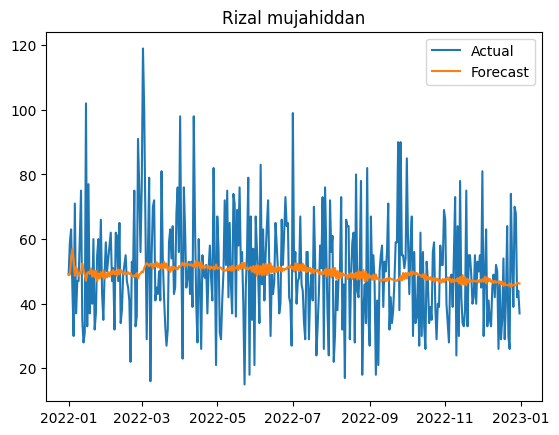

In [54]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
# data = pm.datasets.load_wineind()
# train, test = model_selection.train_test_split(master_df_reg_ar['Qty'], test_size=30)

# Fit a simple auto_arima model
arima_data = pow_tr.transform(master_df_reg['Qty'].to_numpy().reshape((-1,1)))

arima = pm.auto_arima(arima_data,
                      start_p=0, d=None,start_q=0, 
                      max_p=10, max_d=2, max_q=10, 
                      start_P=0, D=None, start_Q=0, 
                      max_P=2, max_D=2, max_Q=2,
                      stationary=False, 
                      information_criterion='aicc',
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=1)

auto_arima_np = pow_tr.inverse_transform(arima.predict(n_periods=30).reshape((-1,1))).ravel()
master_df_autoarima_for = pd.DataFrame({
    'Date':date_for,
    'Qty':auto_arima_np
})

ar_fit_val = pow_tr.inverse_transform(arima.fittedvalues().reshape((-1,1))).ravel()

nilai_mapeku = mean_absolute_percentage_error(y_true=master_df_reg['Qty'],y_pred=ar_fit_val)
nilai_smapeku = smape_metric(y_true=master_df_reg['Qty'],y_pred=ar_fit_val)

print(f'Nilai MAPE  : {nilai_mapeku}')
print(f'Nilai SMAPE : {nilai_smapeku}')

plt.plot(master_df_reg['Date'],
         master_df_reg['Qty'],
         label='Actual')
plt.plot(master_df_reg['Date'],
         pow_tr.inverse_transform(arima.fittedvalues().reshape((-1,1))).ravel(),
         label='Forecast')
plt.title('Rizal mujahiddan')
plt.legend()
plt.show()

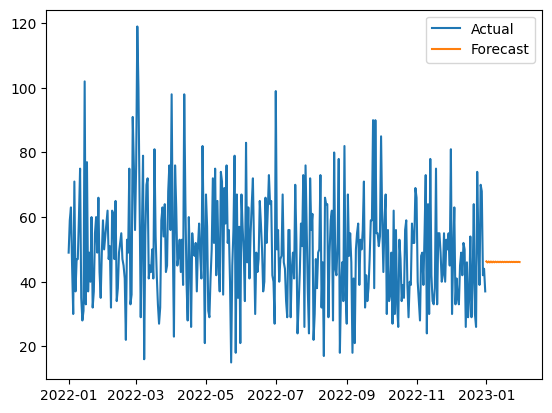

In [55]:
plt.plot(master_df_reg['Date'],master_df_reg['Qty'],label='Actual')
plt.plot(master_df_autoarima_for['Date'],master_df_autoarima_for['Qty'],label='Forecast')
plt.legend()
plt.show()

In [56]:
master_df_autoarima_for.to_csv('Forecast_AutoARIMA.csv',index=True)

## Neural Prophet

In [57]:
from torchmetrics.regression import (
    MeanAbsolutePercentageError,
    MeanAbsoluteError,
    MeanSquaredError,
    SymmetricMeanAbsolutePercentageError,
)

from neuralprophet import (
    NeuralProphet,
    set_log_level,
    set_random_seed
)
set_random_seed(0)
set_log_level("ERROR")

master_df_reg_np = master_df_reg.copy()
master_df_reg_np = master_df_reg_np.rename({'Date':'ds',
                                            'Qty':'y'
                                           },
                                           axis=1)

mod_np = NeuralProphet(
    #growth="off",
    #n_changepoints=365,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive',
    n_lags=10,
    n_forecasts=30,
    #trend_reg=0.5,
    #seasonality_reg=1,
    ar_reg=1,
    ar_layers=[32,32,32],
    collect_metrics={'MAPE':MeanAbsolutePercentageError(),
                     'MAE':MeanAbsoluteError(),
                     'SMAPE':SymmetricMeanAbsolutePercentageError(),
                     #'mse':MeanSquaredError()
                    }
)
# mod_np.add_seasonality('4 days',
#                        period=seasonal_period,
#                        fourier_order=2,
#                       )
mod_np.set_plotting_backend('matplotlib')

# df_train, df_val = mod_np.split_df(master_df_reg_np, freq='D', valid_p = (30/365))
metrics = mod_np.fit(master_df_reg_np, freq='D', 
                     #validation_df=df_val
                    )
display(metrics.head(5))
display(metrics.tail(5))

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Finding best initial lr:   0%|          | 0/216 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,MAPE,SMAPE,Loss,RegLoss,epoch
0,76.223083,1.691383,1.275341,0.582192,0.0,0
1,68.619263,1.527292,1.221876,0.501533,0.0,1
2,62.823956,1.399791,1.180220,0.438130,0.0,2
3,57.815605,1.291099,1.133540,0.386001,0.0,3
4,53.565193,1.196741,1.097174,0.343568,0.0,4


,MAE,MAPE,SMAPE,Loss,RegLoss,epoch
287,9.812617,0.226703,0.204373,0.016004,0.001512,287
288,9.811038,0.226618,0.204229,0.016009,0.001515,288
289,9.773285,0.225953,0.203857,0.015980,0.001518,289
290,9.790499,0.226611,0.204088,0.015929,0.001519,290
291,9.805483,0.225924,0.203960,0.015963,0.001520,291


<Axes: >

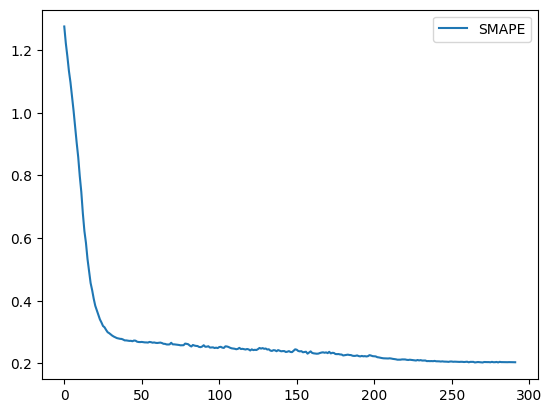

In [58]:
 metrics.plot(y=[#'MAE',
                 #'MAPE',
                 'SMAPE',
                 #'SMAPE_val'
                 #'Loss',
                 #'RegLoss'
                ])

In [59]:
forecast_np = mod_np.make_future_dataframe(master_df_reg_np,n_historic_predictions=True)
display(forecast_np)
forecast_df = mod_np.predict(forecast_np)
forecast_df[['yhat21','yhat22','yhat23','yhat24',
             'yhat25','yhat26','yhat27','yhat28',
             'yhat29','yhat30'
            ]].tail(10)

,ds,y
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30
...,...,...
390,2023-01-26,None
391,2023-01-27,None
392,2023-01-28,None
393,2023-01-29,None


Predicting: 21it [00:00, ?it/s]

,yhat21,yhat22,yhat23,yhat24,yhat25,yhat26,yhat27,yhat28,yhat29,yhat30
385,59.558605,57.600685,62.598389,61.339024,52.401169,55.011211,83.827271,89.761642,57.586567,51.753407
386,NaN,58.585972,56.598362,51.324123,33.717262,65.804703,51.757435,55.099239,76.377388,45.506554
387,NaN,NaN,64.597626,75.122559,54.204594,53.040276,71.353516,80.685493,75.660553,64.072754
388,NaN,NaN,NaN,62.001514,64.632324,70.060379,38.165852,76.111664,56.164482,38.008301
389,NaN,NaN,NaN,NaN,57.162586,57.847515,61.026642,71.279892,68.376366,66.967247
390,NaN,NaN,NaN,NaN,NaN,60.171631,37.481407,49.040154,64.756012,38.621834
391,NaN,NaN,NaN,NaN,NaN,NaN,66.290741,79.136993,65.989464,50.545940
392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.999985,32.618210,68.922760
393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.575790,75.151543
394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.573498


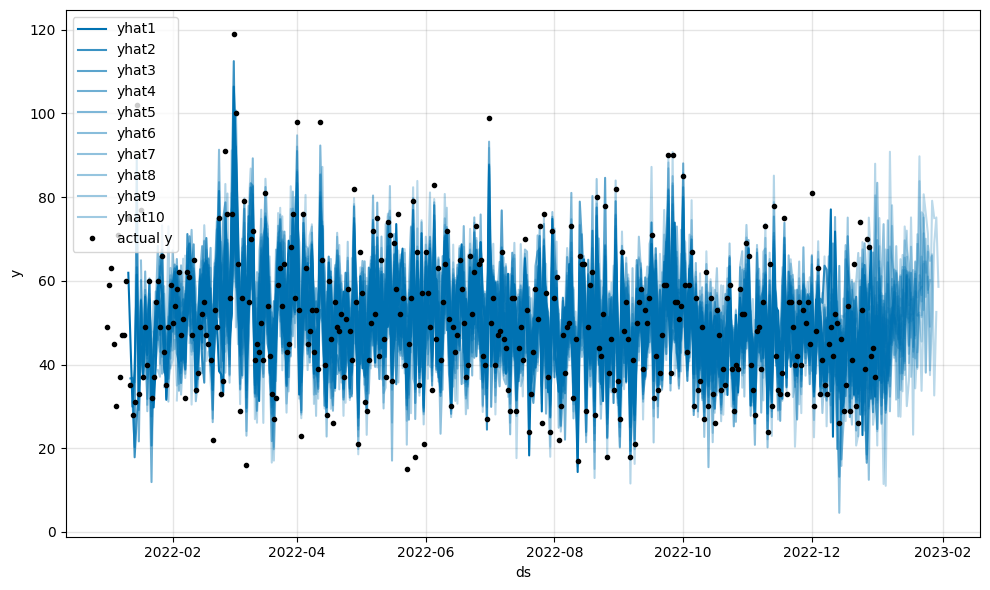

In [60]:
mod_np.plot(forecast_df)

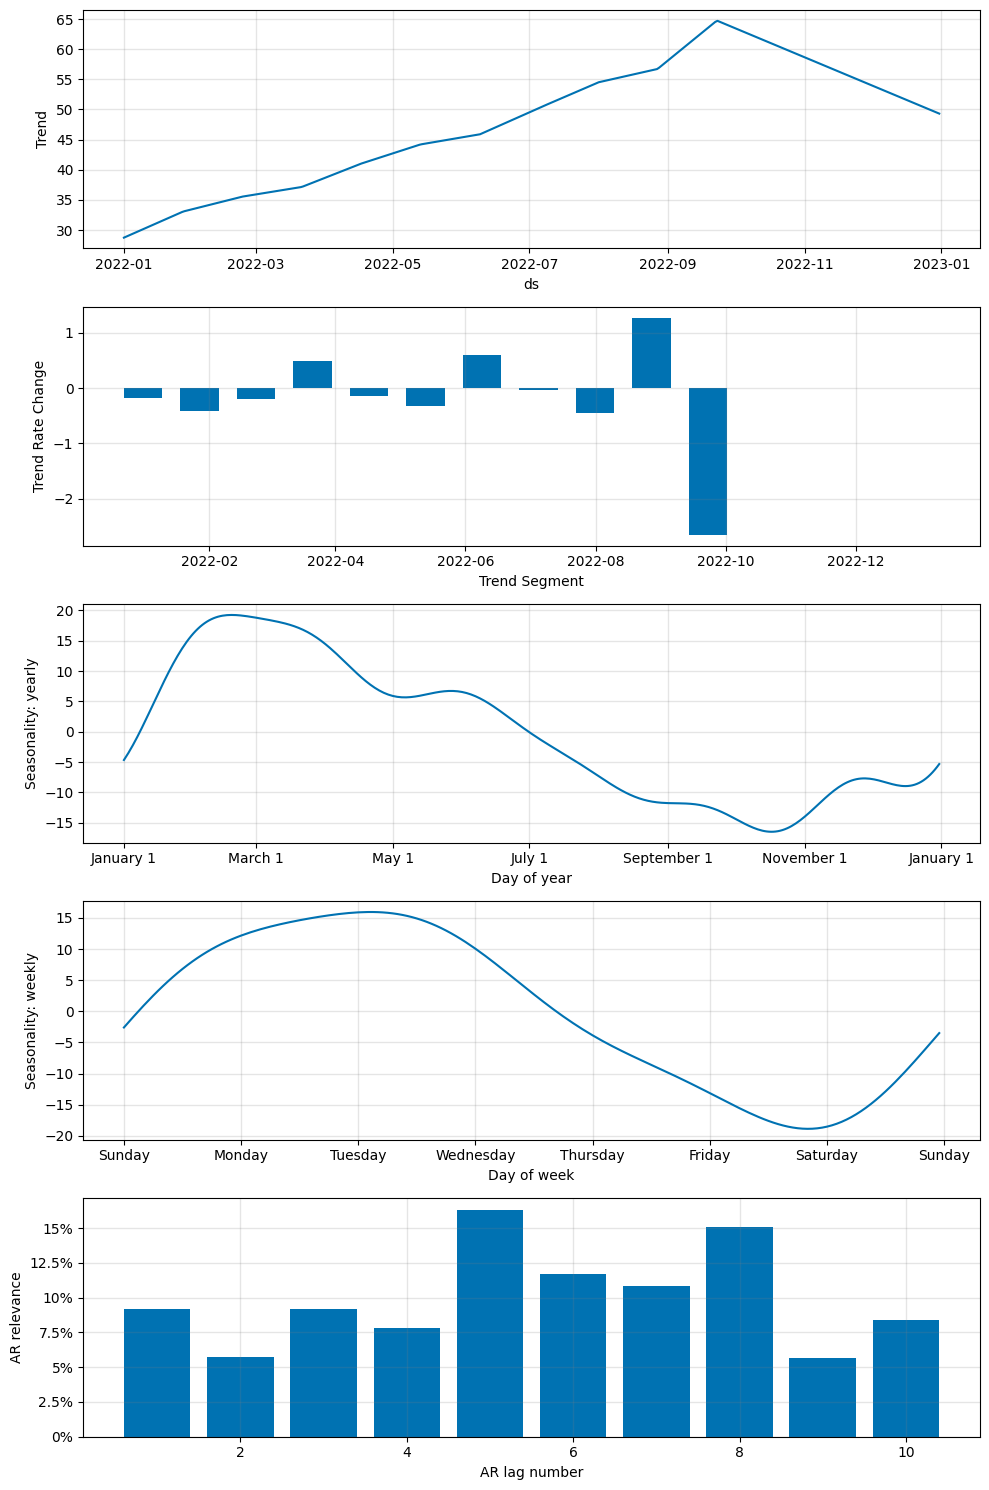

In [61]:
mod_np.plot_parameters()

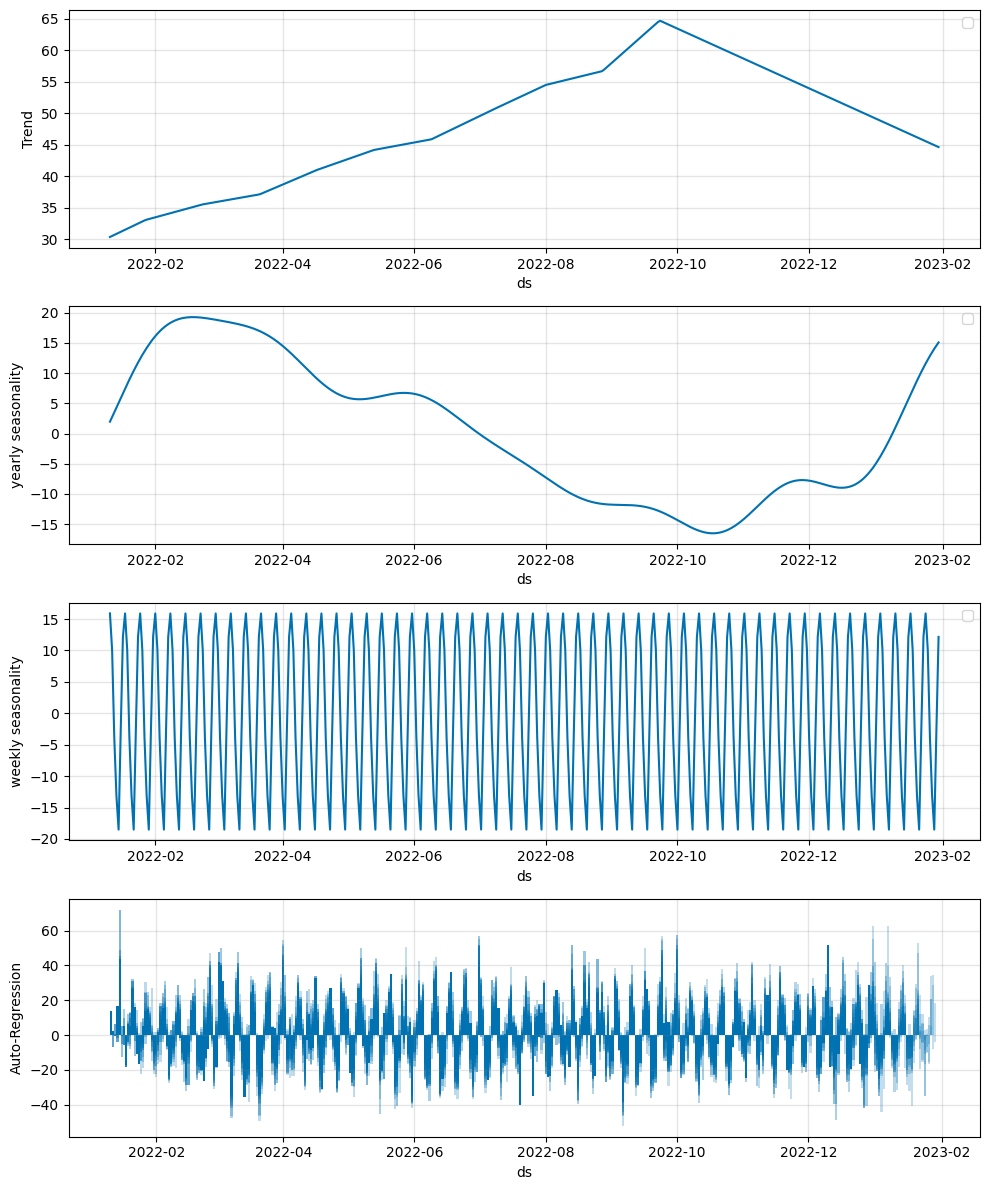

In [62]:
mod_np.plot_components(forecast_df)

In [63]:
hasil_neural_prophet = forecast_df[['ds','yhat30']][365:]
hasil_neural_prophet

,ds,yhat30
365,2023-01-01,24.054699
366,2023-01-02,42.807083
367,2023-01-03,28.115540
368,2023-01-04,50.604847
369,2023-01-05,56.932495
370,2023-01-06,52.498047
371,2023-01-07,68.205765
372,2023-01-08,64.969757
373,2023-01-09,61.373913
374,2023-01-10,47.443111


In [64]:
hasil_neural_prophet = hasil_neural_prophet.rename({
    'ds':'Date',
    'yhat30':'Qty',
},axis=1)
hasil_neural_prophet = hasil_neural_prophet.reset_index(drop=True)
hasil_neural_prophet.to_csv('forecast_NeuralProphet.csv',
                            index=True
                           )
hasil_neural_prophet

,Date,Qty
0,2023-01-01,24.054699
1,2023-01-02,42.807083
2,2023-01-03,28.115540
3,2023-01-04,50.604847
4,2023-01-05,56.932495
5,2023-01-06,52.498047
6,2023-01-07,68.205765
7,2023-01-08,64.969757
8,2023-01-09,61.373913
9,2023-01-10,47.443111


In [65]:
display(summary(mod_np.model))

Layer (type:depth-idx)                                  Param #
├─MetricCollection: 1-1                                 --
|    └─MeanAbsoluteError: 2-1                           --
|    └─MeanAbsolutePercentageError: 2-2                 --
|    └─SymmetricMeanAbsolutePercentageError: 2-3        --
├─MetricCollection: 1-2                                 --
|    └─MeanAbsoluteError: 2-4                           --
|    └─MeanAbsolutePercentageError: 2-5                 --
|    └─SymmetricMeanAbsolutePercentageError: 2-6        --
├─GlobalPiecewiseLinearTrend: 1-3                       13
├─GlobalFourierSeasonality: 1-4                         --
|    └─ParameterDict: 2-7                               18
├─ModuleList: 1-5                                       --
|    └─Linear: 2-8                                      352
|    └─Linear: 2-9                                      1,056
|    └─Linear: 2-10                                     1,056
|    └─Linear: 2-11                         

Layer (type:depth-idx)                                  Param #
├─MetricCollection: 1-1                                 --
|    └─MeanAbsoluteError: 2-1                           --
|    └─MeanAbsolutePercentageError: 2-2                 --
|    └─SymmetricMeanAbsolutePercentageError: 2-3        --
├─MetricCollection: 1-2                                 --
|    └─MeanAbsoluteError: 2-4                           --
|    └─MeanAbsolutePercentageError: 2-5                 --
|    └─SymmetricMeanAbsolutePercentageError: 2-6        --
├─GlobalPiecewiseLinearTrend: 1-3                       13
├─GlobalFourierSeasonality: 1-4                         --
|    └─ParameterDict: 2-7                               18
├─ModuleList: 1-5                                       --
|    └─Linear: 2-8                                      352
|    └─Linear: 2-9                                      1,056
|    └─Linear: 2-10                                     1,056
|    └─Linear: 2-11                         

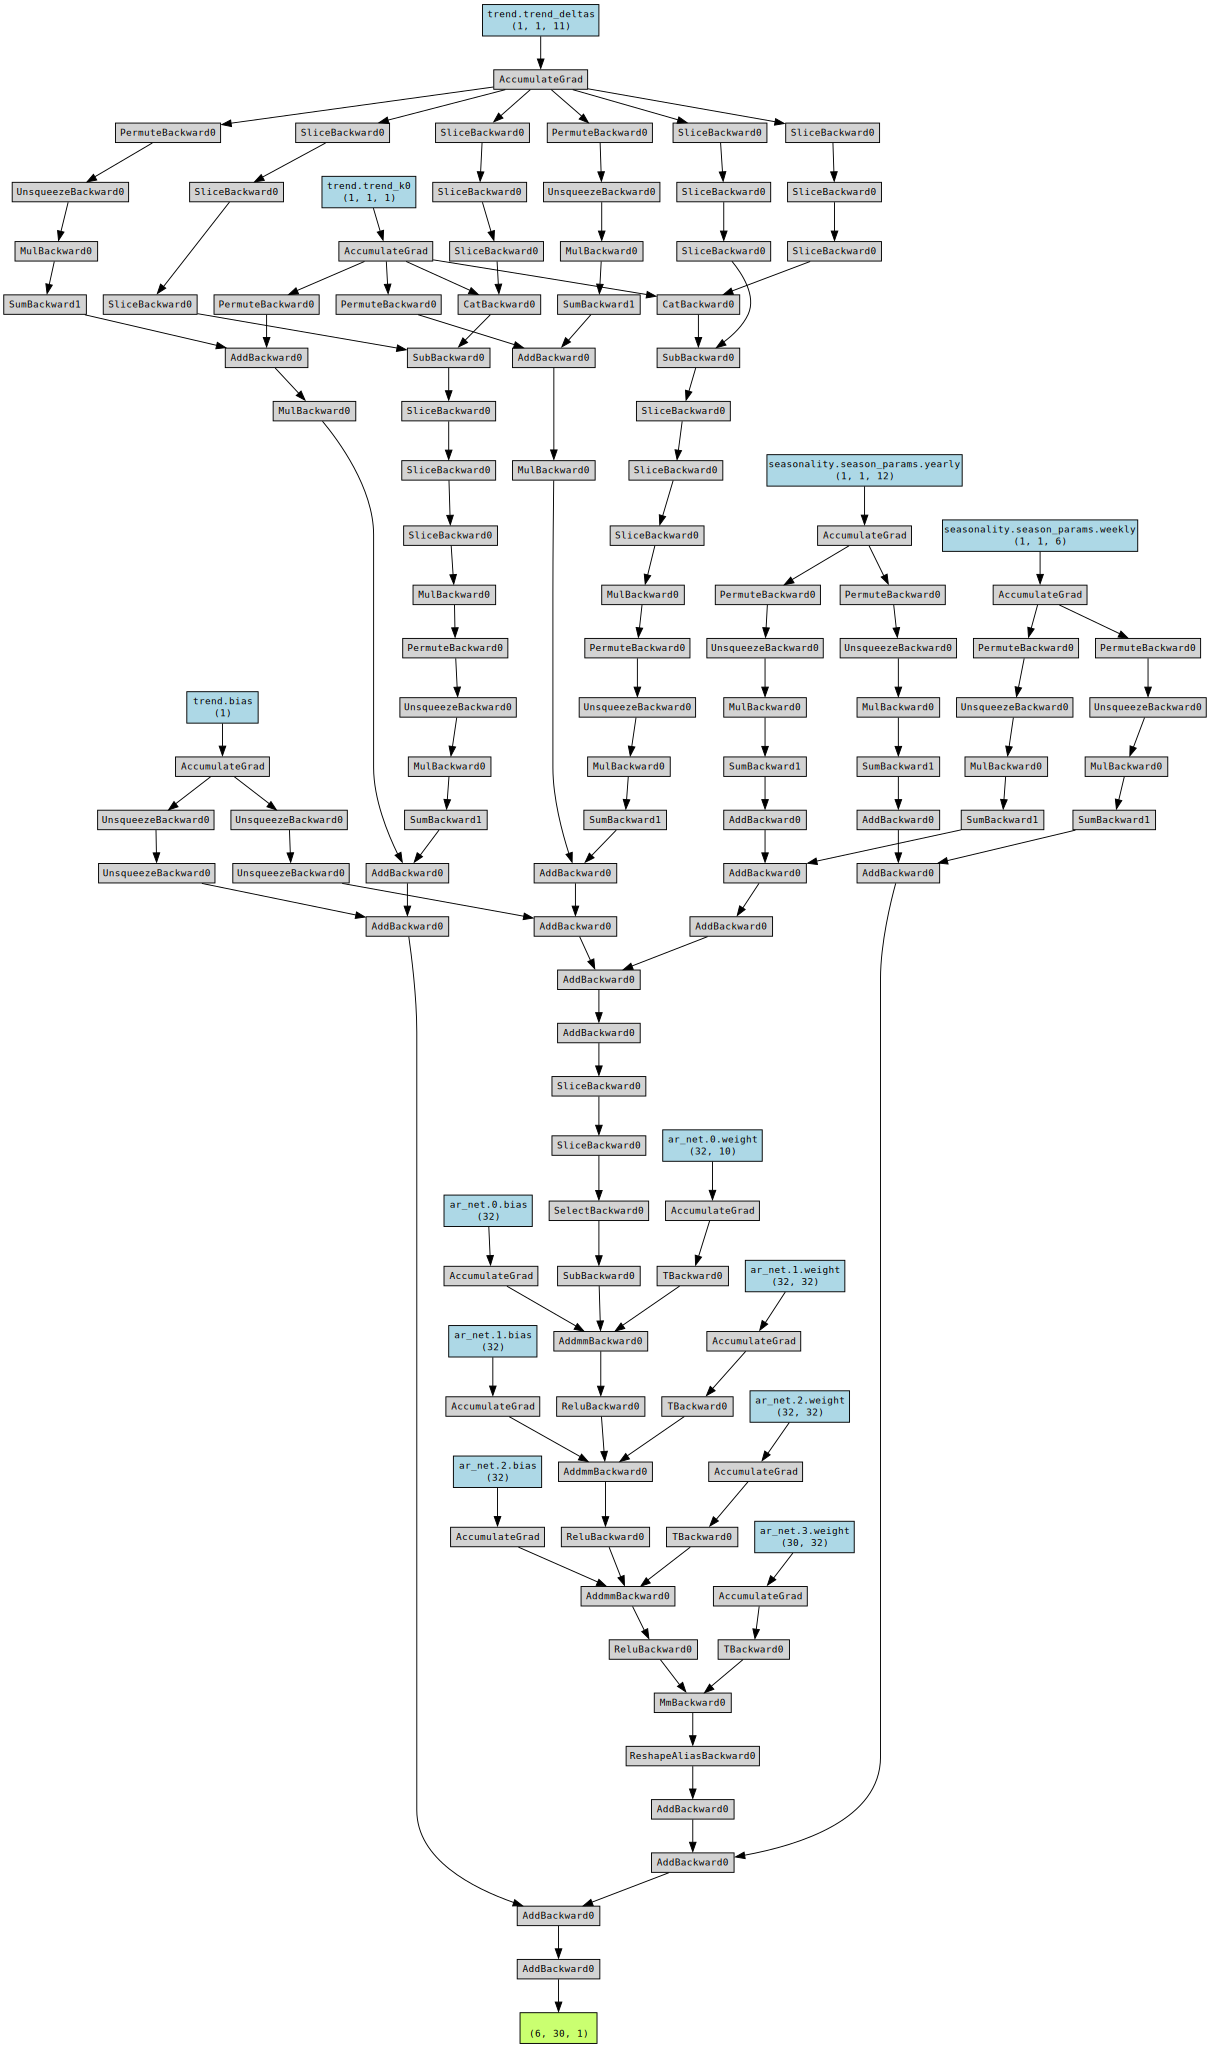

In [66]:
fig = make_dot(mod_np.model.train_epoch_prediction, params=dict(mod_np.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)

## NeuralForecast

In [67]:
from neuralforecast import NeuralForecast
from neuralforecast.models import (
    LSTM,
    NHITS,
    TFT
)
max_stepsku = 1000
horizon = 30

master_df_reg_nf = master_df_reg.copy()
master_df_reg_nf = master_df_reg_nf.rename({
    'Date':'ds',
    'Qty':'y',
},axis=1
)
master_df_reg_nf['unique_id'] = 0
train_nf,test_nf = master_df_reg_nf[:-30],master_df_reg_nf[-30:]

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=max_stepsku,                # Number of steps to train
               #scaler_type='standard',       # Type of scaler to normalize data
               #encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               #decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
              ),
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=max_stepsku,       # Number of steps to train
                #n_freq_downsample=[2, 1, 1]
               ),# Downsampling factors for each stack output
          TFT(h=horizon,
              input_size=horizon,
              max_steps=max_stepsku,
             )
          ]
nf = NeuralForecast(models=models, freq='D')
metrics_nf = nf.fit(df=train_nf)
predict_df_nf = nf.predict()
predict_df_nf

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,ds,LSTM,NHITS,TFT
unique_id,,,,
0,2022-12-02,26.517668,49.511211,30.361134
0,2022-12-03,87.954025,48.236172,31.509426
0,2022-12-04,54.134659,62.214287,38.141842
0,2022-12-05,27.712215,57.177223,40.052475
0,2022-12-06,50.194225,49.380066,50.831371
0,2022-12-07,64.803688,71.092033,52.215630
0,2022-12-08,31.742521,49.983566,48.165314
0,2022-12-09,26.350452,61.438873,42.216049
0,2022-12-10,43.172409,65.709824,40.422249


In [68]:
predict_df_nf = predict_df_nf.reset_index(drop=True)
test_nf = test_nf.rename({'y':'y_test'},axis=1)
display(predict_df_nf)
test_nf

,ds,LSTM,NHITS,TFT
0,2022-12-02,26.517668,49.511211,30.361134
1,2022-12-03,87.954025,48.236172,31.509426
2,2022-12-04,54.134659,62.214287,38.141842
3,2022-12-05,27.712215,57.177223,40.052475
4,2022-12-06,50.194225,49.380066,50.831371
5,2022-12-07,64.803688,71.092033,52.215630
6,2022-12-08,31.742521,49.983566,48.165314
7,2022-12-09,26.350452,61.438873,42.216049
8,2022-12-10,43.172409,65.709824,40.422249
9,2022-12-11,25.244764,59.114803,41.801529


,ds,y_test,unique_id
335,2022-12-02,30,0
336,2022-12-03,48,0
337,2022-12-04,63,0
338,2022-12-05,33,0
339,2022-12-06,41,0
340,2022-12-07,35,0
341,2022-12-08,33,0
342,2022-12-09,45,0
343,2022-12-10,49,0
344,2022-12-11,42,0


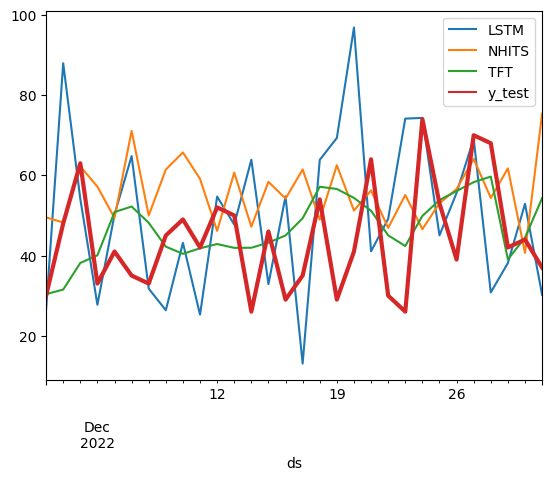

In [69]:
test_nf = test_nf.reset_index(drop=True)
predict_df_nf['y_test'] = test_nf['y_test']
# predict_df_nf.plot(x='ds',y=['LSTM','NHITS','y_test'])
ax = predict_df_nf.plot(x='ds', y=['LSTM', 'NHITS','TFT', 'y_test'])
ax.lines[0].set_linewidth(1.5)
ax.lines[1].set_linewidth(1.5)
ax.lines[2].set_linewidth(1.5)
ax.lines[3].set_linewidth(3)
plt.show()

In [70]:
from sklearn.metrics import mean_absolute_percentage_error
mape_NHITS = mean_absolute_percentage_error(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.NHITS,
                              )
mape_LSTM = mean_absolute_percentage_error(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.LSTM,
                              )
mape_TFT = mean_absolute_percentage_error(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.TFT,
                              )
print(f'MAPE NHITS : {mape_NHITS*100} %')
print(f'MAPE LSTM  : {mape_LSTM*100} %')
print(f'MAPE TFT   : {mape_TFT*100} %')

smape_NHITS = smape_metric(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.NHITS,
                              )
smape_LSTM = smape_metric(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.LSTM,
                              )
smape_TFT = smape_metric(y_true=predict_df_nf.y_test,
                               y_pred=predict_df_nf.TFT,
                              )
print()
print(f'SMAPE NHITS : {smape_NHITS*100} %')
print(f'SMAPE LSTM  : {smape_LSTM*100} %')
print(f'SMAPE TFT   : {smape_TFT*100} %')

MAPE NHITS : 44.30106059586868 %
MAPE LSTM  : 46.84970701949361 %
MAPE TFT   : 28.840392482781496 %

SMAPE NHITS : 33.851039357214994 %
SMAPE LSTM  : 37.568176630663544 %
SMAPE TFT   : 25.49803080278124 %


In [71]:
# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                     # Forecast horizon
               max_steps=max_stepsku,         # Number of steps to train
               #scaler_type='standard',       # Type of scaler to normalize data
               #encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               #decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
              ),
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=max_stepsku,       # Number of steps to train
                #n_freq_downsample=[2, 1, 1]
               ),# Downsampling factors for each stack output
          TFT(h=horizon,
              input_size=horizon,
              max_steps=max_stepsku,
             )
          ]
nf = NeuralForecast(models=models, freq='D')
metrics_nf = nf.fit(df=master_df_reg_nf)
predict_df_nf = nf.predict()
predict_df_nf

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,ds,LSTM,NHITS,TFT
unique_id,,,,
0,2023-01-01,47.314274,46.096226,27.379356
0,2023-01-02,45.469482,57.626469,34.451378
0,2023-01-03,41.970928,44.817303,47.059494
0,2023-01-04,51.002914,37.555809,47.424961
0,2023-01-05,78.345596,54.362862,53.555248
0,2023-01-06,33.891617,30.831415,41.979652
0,2023-01-07,47.084000,51.567574,33.065521
0,2023-01-08,38.919769,33.522186,42.446743
0,2023-01-09,68.777374,46.460121,41.019943


In [72]:
predict_df_nf = predict_df_nf.reset_index(drop=True)
predict_df_nf = predict_df_nf.rename({'LSTM':'y_lstm',
                                      'NHITS':'y_nhits',
                                      'TFT':'y_tft',
                                      'ds':'Date',
                                     },
                                     axis=1
                                    )
predict_df_nf.to_csv('forecast_NeuralForecast.csv',index=False)

## Pycaret Regression

In [73]:
from pycaret.time_series import TSForecastingExperiment

master_df_reg_pyc = master_df_reg.set_index('Date')
print(master_df_reg_pyc.shape)
py_ts = TSForecastingExperiment()

py_ts.setup(data=master_df_reg_pyc,
            target='Qty',
            fh=30,
            num_sps_to_use=-1,
            max_sp_to_consider=((365-1)/2),
            session_id=42,
           )
nama_model = py_ts.models().index.tolist()
print(nama_model)
model_terbaik = py_ts.compare_models(include=nama_model)

(365, 1)


,Description,Value
0,session_id,42
1,Target,Qty
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(365, 1)"
5,Transformed data shape,"(365, 1)"
6,Transformed train set shape,"(335, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


['naive', 'grand_means', 'polytrend', 'arima', 'auto_arima', 'exp_smooth', 'ets', 'theta', 'croston', 'bats', 'tbats', 'prophet', 'lr_cds_dt', 'en_cds_dt', 'ridge_cds_dt', 'lasso_cds_dt', 'llar_cds_dt', 'br_cds_dt', 'huber_cds_dt', 'omp_cds_dt', 'knn_cds_dt', 'dt_cds_dt', 'rf_cds_dt', 'et_cds_dt', 'gbr_cds_dt', 'ada_cds_dt', 'xgboost_cds_dt', 'lightgbm_cds_dt', 'catboost_cds_dt']


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,0.6173,0.6096,11.9334,15.0379,0.2890,0.2508,-0.0480,0.0533
bats,BATS,0.6178,0.6056,11.9452,14.9390,0.2821,0.2513,-0.0295,4.9333
tbats,TBATS,0.6178,0.6056,11.9452,14.9390,0.2821,0.2513,-0.0295,10.0733
exp_smooth,Exponential Smoothing,0.6183,0.6088,11.9546,15.0177,0.2868,0.2513,-0.0432,0.0567
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6188,0.6093,11.9633,15.0308,0.2868,0.2515,-0.0448,0.3933
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.6188,0.6093,11.9633,15.0308,0.2868,0.2515,-0.0448,0.3900
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.6188,0.6093,11.9633,15.0308,0.2868,0.2515,-0.0448,0.6033
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6188,0.6093,11.9642,15.0311,0.2869,0.2515,-0.0449,0.3867
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6189,0.6093,11.9650,15.0314,0.2869,0.2515,-0.0449,0.3900
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6189,0.6093,11.9650,15.0314,0.2869,0.2515,-0.0449,0.3833


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

In [74]:
model_terbaik_hyp = py_ts.tune_model(model_terbaik)


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-09-02,0.6167,0.6698,12.1211,16.7630,0.2843,0.2428,-0.0177
1,2022-10-02,0.6132,0.5511,11.8873,13.6427,0.3136,0.2630,-0.1234
2,2022-11-01,0.6220,0.6079,11.7918,14.7080,0.2692,0.2465,-0.0029
Mean,NaT,0.6173,0.6096,11.9334,15.0379,0.2890,0.2508,-0.0480
SD,NaT,0.0036,0.0485,0.1383,1.2951,0.0184,0.0088,0.0537


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


In [75]:
model_terbaik_final = py_ts.finalize_model(model_terbaik_hyp)

In [76]:
py_ts.plot_model(model_terbaik_final,plot='diagnostics')
plt.show()

In [77]:
py_ts.plot_model(model_terbaik_final)
plt.show()

In [78]:
py_ts.plot_model(model_terbaik_final,plot='cv')
plt.show()

In [79]:
forecast_pycaret_reg = py_ts.predict_model(model_terbaik_final,X=master_df_reg_pyc)
forecast_pycaret_reg = forecast_pycaret_reg.reset_index(drop=False)
forecast_pycaret_reg = forecast_pycaret_reg.rename({'index':'Date',
                                                    'y_pred':'Qty',
                                                   },
                                                   axis=1
                                                  )
forecast_pycaret_reg

,Date,Qty
0,2023-01-01,46.8858
1,2023-01-02,46.8752
2,2023-01-03,46.8645
3,2023-01-04,46.8538
4,2023-01-05,46.8431
5,2023-01-06,46.8324
6,2023-01-07,46.8217
7,2023-01-08,46.8111
8,2023-01-09,46.8004
9,2023-01-10,46.7897


In [80]:
model_terbaik_final

ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                ThetaForecaster())]))])

Model yang optimal adalah dengan menggunakan theta model dibanding model lainnya

|      Model     |   MAPE   |   SMAPE   |
|----------------|----------|-----------|
| Neural Prophet | 22,59 %  |  20,40 %  |
| Theta model    | 28,90 %  |  25,08 %  |
| TFT            | 28,84 %  |  25,50 %  |
| Arima          | 31,54 %  |  26,65 %  |
| NHITS          | 44,30 %  |  33,85 %  |
| LSTM           | 46,85 %  |  37,56 %  |

Yang terbaik adalah Dengan menggunakan Neuralprophet model, Kemudian lebih baik menggunakan Theta Model karena TFT bagus tetapi waktu komputasinya lumayan tinggi. NeuralProphet bagus karena menggunakan persepsi statistik dan deep learning.

# Clustering

In [81]:
master_df = pd.merge(trans_df,store_df,
                     left_on='StoreID',
                     right_on='StoreID',
                     #how='left'
                    )
master_df = pd.merge(master_df,product_df,
                     left_on='ProductID',
                     right_on='ProductID',
                     #how='left'
                    )
master_df = pd.merge(master_df,customer_df,
                     left_on='CustomerID',
                     right_on='CustomerID',
                     #how='left'
                    )
master_df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y,Age,Gender,Marital Status,Income
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500,36,0,Married,10.53
1,TR57013,328,15/09/2022,P7,9400,6,56400,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Coffee Candy,9400,36,0,Married,10.53
2,TR97172,328,21/05/2022,P1,8800,5,44000,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Choco Bar,8800,36,0,Married,10.53
3,TR67395,328,22/01/2022,P8,16000,3,48000,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Oat,16000,36,0,Married,10.53
4,TR45738,328,29/12/2022,P2,3200,3,9600,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Ginger Candy,3200,36,0,Married,10.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR37670,193,26/09/2022,P5,4200,2,8400,7,Buana Indah,Buana,General Trade,3.316694,114.590111,Thai Tea,4200,42,0,Married,20.64
5016,TR98043,385,27/06/2022,P2,3200,7,22400,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Ginger Candy,3200,41,1,Married,15.84
5017,TR91332,385,09/01/2022,P9,10000,1,10000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt,10000,41,1,Married,15.84
5018,TR88968,385,21/08/2022,P9,10000,6,60000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Yoghurt,10000,41,1,Married,15.84


In [82]:
master_df.Date = pd.to_datetime(master_df.Date,format="%d/%m/%Y")
master_df.dtypes

TransactionID             object
CustomerID                 int64
Date              datetime64[ns]
ProductID                 object
Price_x                    int64
Qty                        int64
TotalAmount                int64
StoreID                    int64
StoreName                 object
GroupStore                object
Type                      object
Latitude                 float64
Longitude                float64
Product Name              object
Price_y                    int64
Age                        int64
Gender                     int64
Marital Status            object
Income                   float64
dtype: object

In [83]:
master_df = master_df.drop(['Price_y'],axis=1)
master_df = master_df.rename({'Price_x':'Price'},axis=1)
master_df

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,36,0,Married,10.53
1,TR57013,328,2022-09-15,P7,9400,6,56400,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Coffee Candy,36,0,Married,10.53
2,TR97172,328,2022-05-21,P1,8800,5,44000,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Choco Bar,36,0,Married,10.53
3,TR67395,328,2022-01-22,P8,16000,3,48000,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Oat,36,0,Married,10.53
4,TR45738,328,2022-12-29,P2,3200,3,9600,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Ginger Candy,36,0,Married,10.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR37670,193,2022-09-26,P5,4200,2,8400,7,Buana Indah,Buana,General Trade,3.316694,114.590111,Thai Tea,42,0,Married,20.64
5016,TR98043,385,2022-06-27,P2,3200,7,22400,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403,Ginger Candy,41,1,Married,15.84
5017,TR91332,385,2022-01-09,P9,10000,1,10000,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513,Yoghurt,41,1,Married,15.84
5018,TR88968,385,2022-08-21,P9,10000,6,60000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Yoghurt,41,1,Married,15.84


In [84]:
master_df_clus = master_df.groupby(['CustomerID']).agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
})

profile = ProfileReport(master_df_clus, title="EDA master df clus")
profile.to_file('EDA_master_df_clus.html')
master_df_clus

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,TransactionID,Qty,TotalAmount
CustomerID,,,
1,17,60,623300
2,13,57,392300
3,15,56,446200
4,10,46,302500
5,7,27,268600
...,...,...,...
443,16,59,485100
444,18,62,577700
445,18,68,587200


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer

# Assuming you have your data loaded into a variable named 'data'
norm_cl = Normalizer()
data = norm_cl.fit_transform(master_df_clus)
# Using the Elbow Method (Distortion/Inertia):
distortions = []
K = range(2, 11)  # Start from 2 clusters
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

# Using the Silhouette Score:
silhouette_scores = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data)
    score = silhouette_score(data, kmeanModel.labels_)
    silhouette_scores.append(score)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, linestyle='-', marker='o', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method For Optimal k')

# Plot the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, linestyle='-', marker='o', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()

In [86]:
from pycaret.clustering import ClusteringExperiment
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
ssc.fit(master_df_clus)

py_clu = ClusteringExperiment()
py_clu.setup(data=master_df_clus,
             normalize=True,             
            )


model_clus = py_clu.create_model('kmeans',
                                 num_clusters=3,
                                )
model_clus

,Description,Value
0,Session id,3833
1,Original data shape,"(447, 3)"
2,Transformed data shape,"(447, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4287,717.2169,0.7494,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

KMeans(n_clusters=3, random_state=3833)

2 : 0.4853	653.4641	0.7190	0	0	0 <br>
3 : 0.4287	717.2169	0.7494	0	0	0 <br>
4 : 0.3772	682.4251	0.8300	0	0	0 <br>
5 : 0.3426	660.6022	0.9202	0	0	0 <br>

In [87]:
py_clu.plot_model(model_clus,plot='cluster')

In [88]:
# evaluate_model(kmeans)
py_clu.evaluate_model(model_clus)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [89]:
clus_ans_df = py_clu.predict_model(model_clus,
                     data=master_df_clus
                    )
clus_ans_df

,TransactionID,Qty,TotalAmount,Cluster
CustomerID,,,,
1,1.779816,1.496527,2.094768,Cluster 0
2,0.545884,1.261093,0.239269,Cluster 0
3,1.162850,1.182615,0.672218,Cluster 0
4,-0.379565,0.397833,-0.482047,Cluster 2
5,-1.305014,-1.093251,-0.754347,Cluster 1
...,...,...,...,...
443,1.471333,1.418049,0.984681,Cluster 0
444,2.088298,1.653484,1.728488,Cluster 0
445,2.088298,2.124352,1.804796,Cluster 0


In [90]:
coba = ssc.inverse_transform(clus_ans_df[['TransactionID','Qty','TotalAmount']])
coba = pd.DataFrame(coba,columns=['TransactionID','Qty','TotalAmount'])
coba = coba.astype('int')
coba['CustomerID'] = clus_ans_df.index
coba = coba.set_index('CustomerID')
clus_ans_df[['TransactionID','Qty','TotalAmount']] = coba
clus_ans_df

,TransactionID,Qty,TotalAmount,Cluster
CustomerID,,,,
1,17,60,623300,Cluster 0
2,13,57,392300,Cluster 0
3,15,56,446200,Cluster 0
4,10,46,302500,Cluster 2
5,7,27,268600,Cluster 1
...,...,...,...,...
443,16,59,485100,Cluster 0
444,18,62,577700,Cluster 0
445,18,68,587200,Cluster 0


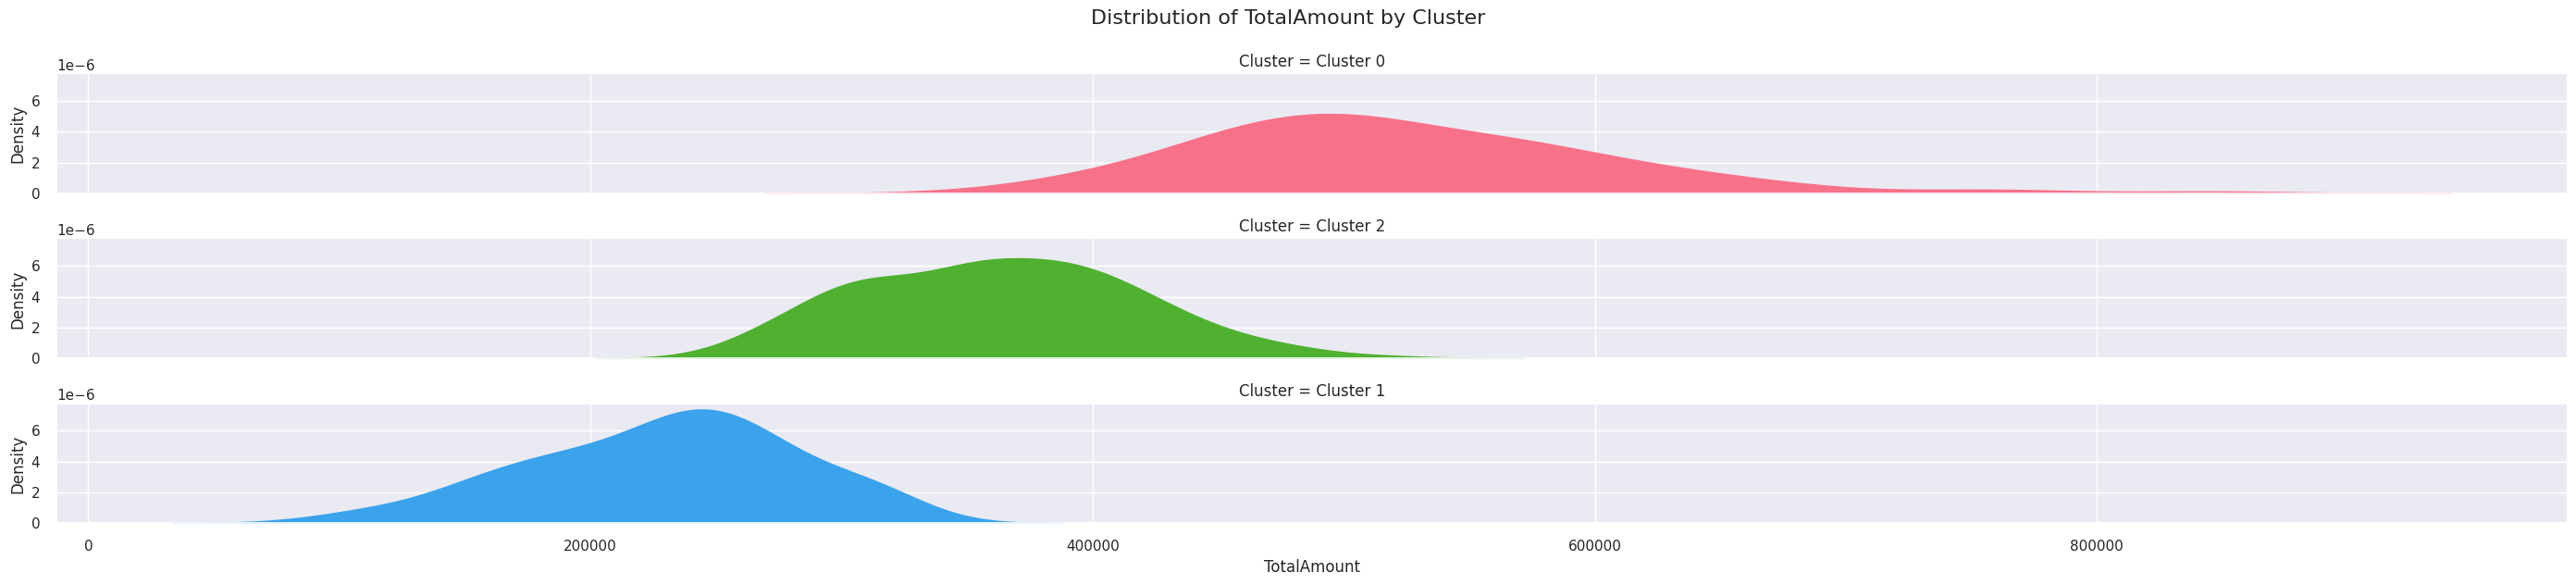

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size using sns.set()
sns.set(font_scale=1)  # You can adjust the font scale as needed

# Define the number of colors you want
num_colors = 3  # You can change this to any number you prefer

# Create a custom colorful palette with the specified number of colors
custom_palette = sns.color_palette("husl", n_colors=num_colors)

# Create a FacetGrid with row faceting and set plot size, specifying the palette
g = sns.FacetGrid(data=clus_ans_df, row='Cluster',hue="Cluster", height=2, aspect=14, palette=custom_palette)

# Map the KDE plot to each facet
g.map(sns.kdeplot, 'TotalAmount', 
      #bw_adjust=.5, 
      #clip_on=False, 
      fill=True, alpha=1, linewidth=1.5)

# Adjust the plot layout (optional)
g.set_axis_labels('TotalAmount', 'Density')

# Show the plot
plt.suptitle("Distribution of TotalAmount by Cluster", y=1.05, fontsize=16)
plt.show()

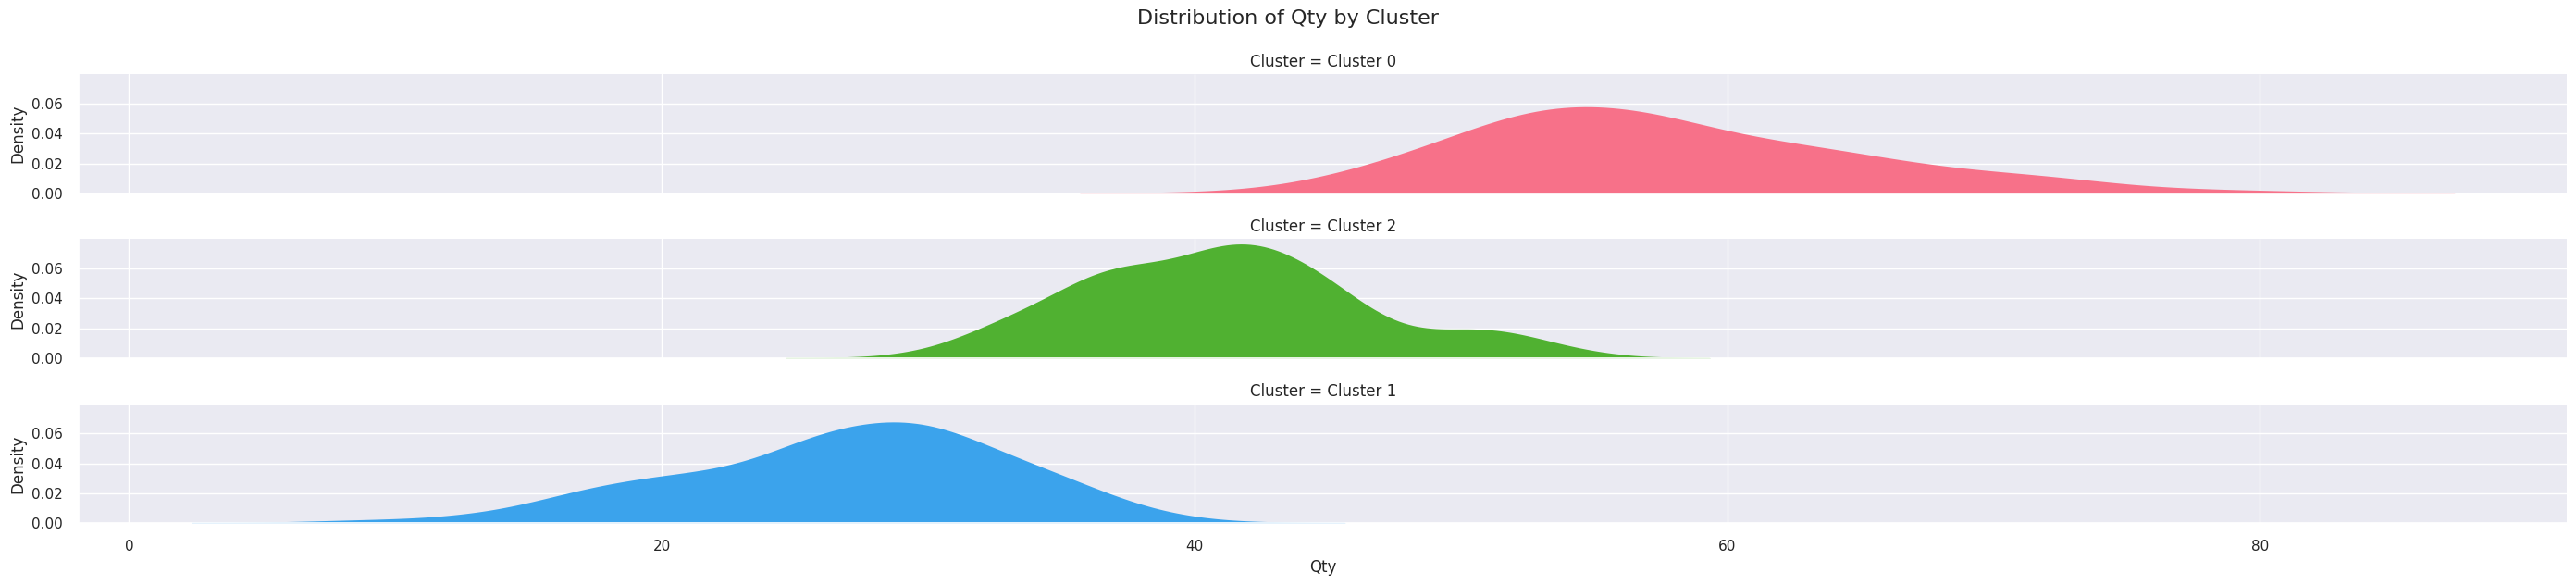

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size using sns.set()
sns.set(font_scale=1)  # You can adjust the font scale as needed

# Define the number of colors you want
num_colors = 3  # You can change this to any number you prefer

# Create a custom colorful palette with the specified number of colors
custom_palette = sns.color_palette("husl", n_colors=num_colors)

# Create a FacetGrid with row faceting and set plot size, specifying the palette
g = sns.FacetGrid(data=clus_ans_df, row='Cluster',hue="Cluster", height=2, aspect=14, palette=custom_palette)

# Map the KDE plot to each facet
g.map(sns.kdeplot, 'Qty', 
      #bw_adjust=.5, 
      #clip_on=False, 
      fill=True, alpha=1, linewidth=1.5)

# Adjust the plot layout (optional)
g.set_axis_labels('Qty', 'Density')


# Show the plot
plt.suptitle("Distribution of Qty by Cluster", y=1.05, fontsize=16)
plt.show()

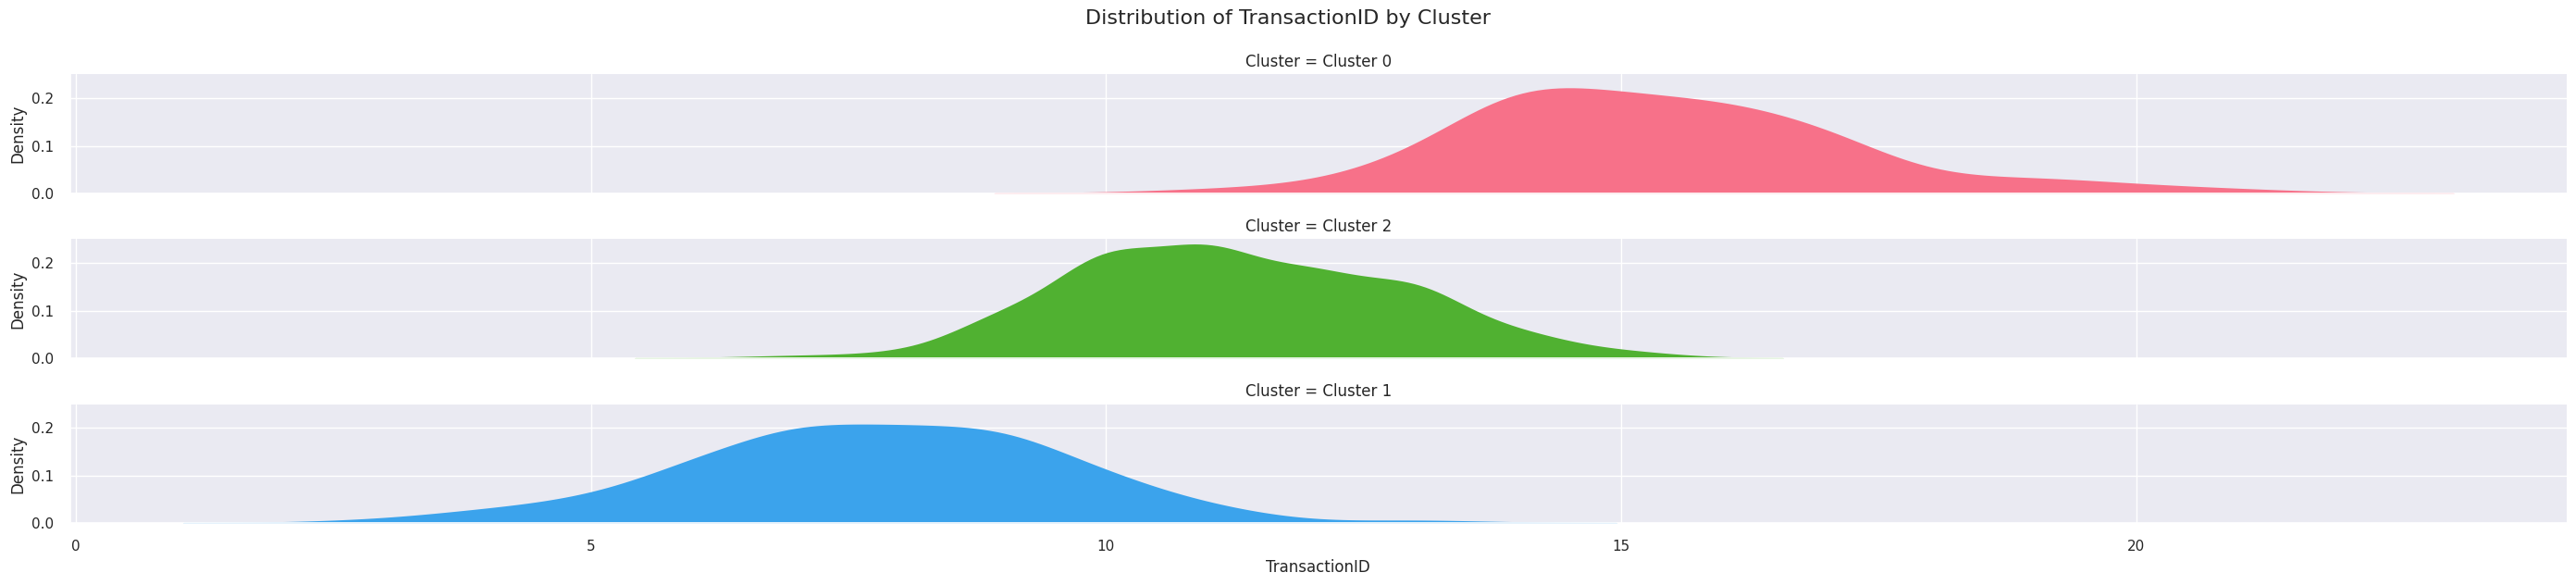

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font size using sns.set()
sns.set(font_scale=1)  # You can adjust the font scale as needed

# Define the number of colors you want
num_colors = 3  # You can change this to any number you prefer

# Create a custom colorful palette with the specified number of colors
custom_palette = sns.color_palette("husl", n_colors=num_colors)

# Create a FacetGrid with row faceting and set plot size, specifying the palette
g = sns.FacetGrid(data=clus_ans_df, row='Cluster',hue="Cluster", height=2, aspect=14, palette=custom_palette)

# Map the KDE plot to each facet
g.map(sns.kdeplot, 'TransactionID', 
      #bw_adjust=.5, 
      #clip_on=False, 
      fill=True, alpha=1, linewidth=1.5)

# Adjust the plot layout (optional)
g.set_axis_labels('TransactionID', 'Density')

# Show the plot
plt.suptitle("Distribution of TransactionID by Cluster", y=1.05, fontsize=16)
plt.show()


In [94]:
for clus_name in sorted(clus_ans_df.Cluster.unique()):
    #print(clus_ans_df[clus_ans_df.Cluster == clus_ans_df])
    print(f"{clus_name}")
    display(clus_ans_df[clus_ans_df.Cluster == clus_name].describe())
    print()
    print("="*64)
    print()

Cluster 0


,TransactionID,Qty,TotalAmount
count,111.000000,111.000000,111.000000
mean,15.351351,57.558559,523573.873874
std,1.776865,7.071948,81200.111634
min,11.000000,44.000000,365000.000000
25%,14.000000,53.000000,470500.000000
50%,15.000000,57.000000,509900.000000
75%,16.000000,62.000000,574300.000000
max,21.000000,79.000000,846700.000000




Cluster 1


,TransactionID,Qty,TotalAmount
count,134.000000,134.000000,134.000000
mean,7.768657,26.858209,229173.880597
std,1.733848,5.883778,52541.360620
min,3.000000,9.000000,92100.000000
25%,7.000000,22.500000,191925.000000
50%,8.000000,28.000000,234550.000000
75%,9.000000,31.000000,264375.000000
max,13.000000,39.000000,329300.000000




Cluster 2


,TransactionID,Qty,TotalAmount
count,202.000000,202.000000,202.000000
mean,11.262376,41.123762,362460.396040
std,1.511307,5.135917,53427.572361
min,7.000000,30.000000,257600.000000
25%,10.000000,37.000000,318300.000000
50%,11.000000,41.000000,362300.000000
75%,12.000000,44.000000,402325.000000
max,15.000000,54.000000,516600.000000


Cluster 0 :
- TransactionID :     3 -     13
- Qty           :     9 -     39
- TotalAmount   : 92100 - 329300

Cluster 1 :
- TransactionID :     11  -     21
- Qty           :     44  -     79
- TotalAmount   : 365000  - 846700

Cluster 2 :
- TransactionID :      7  -     15
- Qty           :     30  -     54
- TotalAmount   : 257600  - 516600

### Rentang Perpotongan

Rentang nilai yang bisa jadi Cluster 0/1 :
- TransactionID : 11 - 12
- Qty           : Null
- TotalAmount   : Null

Rentang nilai yang bisa jadi Cluster 0/2 :
- TransactionID :      7 -     13
- Qty           :     30 -     39
- TotalAmount   : 257600 - 329300

Rentang nilai yang bisa jadi Cluster 1/2:
- TransactionID :     11 -     15
- Qty           :     30 -     44
- TotalAmount   : 365000 - 516600

Rentang nilai yang bisa jadi Cluster 0/1/2 :
- TransactionID : 11 - 13
- Qty           : null
- TotalAmount   : null


ada wilayah yang bisa menjadi kemungkinan pada Cluster 0/2 dan Cluster 1/2. Hal ini mampu membingungkan model tersebut jika ada data baru dengan rentang tersebut.


## Segmentasi customer

Segmentasi customer bisa dibagi berdasarkan tingkat pembelian (pembelajaan)
Biasa :
- Banyak Transaksi               :     3 -     13
- Banyak barang                  :     9 -     39
- Banyak uang yang dibelanjakan  : 92100 - 329300

Loyal :
- Banyak Transaksi               :      7  -     15
- Banyak barang                  :     30  -     54
- Banyak uang yang dibelanjakan  : 257600  - 516600

Sangat Loyal :
- Banyak Transaksi               :     11  -     21
- Banyak barang                  :     44  -     79
- Banyak uang yang dibelanjakan  : 365000  - 846700